# **Report Group 12** 


#### **Loading packages**


In [1]:
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb
from gymPacMan_new_reward import gymPacMan_parallel_env
import torch.nn.functional as F
from collections import deque
import random
import os
from dataclasses import dataclass
import pandas as pd

import cProfile
import pstats

torch.autograd.set_detect_anomaly(True)


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

wandb.login(key = '', relogin = True)
team_name = 'RL_PacMan'

from util_functions import *


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Running on the CPU


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/seppe/.netrc


Running on the CPU


# **Section 1: All functions**

## **Networks**


### Agent networks


#### CNN

In [2]:
class AgentQNetwork(nn.Module):
    def __init__(self,obs_shape, action_dim,hidden_dim=64):
        super(AgentQNetwork, self).__init__()
        self.c1 = nn.Conv2d(obs_shape[0], 32, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(32, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.c3 = nn.Conv2d(hidden_dim, 4*hidden_dim, kernel_size=3, stride=1, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(4*hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)


    def forward(self, obs):
        x = torch.relu(self.c1(obs))
        x = torch.relu(self.c2(x))
        x = torch.relu(self.c3(x))
        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

#### LSTM

In [ ]:
# Define the CNN-LSTM-Q Network


class CNNLSTMQNetwork_hidden(nn.Module):
    def __init__(self, embed_dim, obs_shape, action_space):
        super(CNNLSTMQNetwork_hidden, self).__init__()
        self.embed_dim = embed_dim

        # Shared encoder for the agent's state
        self.shared_encoder = nn.Sequential(
            nn.Conv2d(obs_shape[0], 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to handle varying input sizes
        )

        # Fully connected layer to project encoded state to embed_dim
        self.fc = nn.Linear(128 * 1 * 1, embed_dim)

        # LSTM layer to model temporal dependencies
        self.lstm = nn.LSTM(embed_dim, embed_dim, num_layers=1, batch_first=True)

        # Final layer to compute Q-values
        self.final_layer = nn.Sequential(
            nn.Linear(embed_dim, action_space),
            nn.SiLU()  # Swish activation
        )

    def forward(self, state, hidden):
        # Process single state using the shared encoder
        cnn_features = []
        for t in range(5):
            
            encoded_state = self.shared_encoder(state[:, t, :, :, :])  # Encode the state
            encoded_state = encoded_state.view(encoded_state.size(0), -1)  # Flatten to [batch_size, 128 * 1 * 1]
            projected_state = self.fc(encoded_state).unsqueeze(1)  # Project to embed_dim and add sequence dimension
            cnn_features.append(projected_state)
            
        cnn_features = torch.cat(cnn_features, dim=1)  # Shape: (batch_size, seq_len, cnn_output_size)
        # Apply LSTM to model temporal dependencies
        hx, cx = hidden[0, :, :, :], hidden[1, :, :, :]
        lstm_out, (hx, cx) = self.lstm(cnn_features, (hx, cx))
        hidden_new = torch.stack([hx.detach(), cx.detach()], dim=0)
        # Use the output of the LSTM for the final layer
        q_values = self.final_layer(lstm_out[:, -1, :])  # Shape: [batch_size, action_space]

        return q_values, hidden_new

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.embed_dim),
                torch.zeros(1, batch_size, self.embed_dim))


### Mixing Networks

#### Simple

In [3]:
class SimpleQMixer(nn.Module):
    def __init__(self, n_agents, state_shape):
        """
        Simple QMIX Mixing Network with Convolutional layers.
        Args:
            n_agents (int): Number of agents.
            state_shape (tuple): Shape of the agent-specific input (n_agents, channels, H, W).
        """
        super(SimpleQMixer, self).__init__()
        
        self.n_agents = n_agents
        self.state_shape = state_shape

        self.conv = nn.Sequential(
            nn.Conv2d(state_shape[1], 16, kernel_size=3, stride=1, padding=1),  # state_shape[1] = number of channels
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        dummy_input = torch.zeros(1, state_shape[1], state_shape[2], state_shape[3])  # [batch_size=1, channels, H, W]
        conv_output_size = self.conv(dummy_input).view(1, -1).size(1)
        
        # Hypernetwork layers
        self.hyper_w = nn.Sequential(
            nn.Linear(conv_output_size * n_agents, 64),
            nn.ReLU(),
            nn.Linear(64, n_agents)
        )
        
        self.hyper_b = nn.Sequential(
            nn.Linear(conv_output_size * n_agents, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, agent_qs, agent_states):
        """
        Forward pass for the mixing network with Convolutional layers.
        Args:
            agent_qs (torch.Tensor): Tensor of shape [batch_size, n_agents] containing Q-values for each agent.
            agent_states (torch.Tensor): Tensor of shape [batch_size, n_agents, channels, H, W].
        Returns:
            torch.Tensor: Global Q-value of shape [batch_size, 1].
        """
        batch_size, num_agents, channels, height, width = agent_states.shape
        
        agent_states_r = agent_states.view(batch_size * num_agents, channels, height, width)  # [batch_size * n_agents, channels, H, W]
        
        conv_features = self.conv(agent_states_r)  # [batch_size * n_agents, conv_channels, H, W]
        flattened_features = conv_features.view(batch_size, num_agents, -1)  # [batch_size, n_agents, conv_output_size]
        
        combined_features = flattened_features.view(batch_size, -1)  # [batch_size, n_agents * conv_output_size]
        
        w = torch.abs(self.hyper_w(combined_features)).view(batch_size, self.n_agents, 1)
        b = self.hyper_b(combined_features).view(batch_size, 1, 1)
        
        mixed_qs = torch.bmm(agent_qs.unsqueeze(1), w).squeeze(1) + b
        
        return mixed_qs




#### Attention

In [ ]:

class AttentionMixer(nn.Module):
    def __init__(self, n_agents, state_shape=(2, 8, 10, 20), embed_dim=32, n_heads=4):
        super(AttentionMixer, self).__init__()

        self.n_agents = n_agents
        self.state_shape = state_shape[1:]  # Remove agent dimension
        self.embed_dim = embed_dim
        self.n_heads = n_heads

        # Shared Conv2D encoder for each agent
        self.shared_encoder = nn.Sequential(
            nn.Conv2d(self.state_shape[0], 16, kernel_size=3, stride=1, padding='same'),
            nn.SiLU(),  # Swish activation
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same'),
            nn.SiLU(),  # Swish activation
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.SiLU(),  # Swish activation
            nn.AdaptiveAvgPool2d(1)
        )

        # Fully connected layer to project to embed_dim
        self.fc = nn.Sequential(
            nn.Linear(64, embed_dim),
            nn.SiLU()  # Swish activation
        )

        for m in self.shared_encoder:
            if isinstance(m, nn.Conv2d):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)
        for m in self.fc:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

        # Multi-head attention for inter-agent interaction
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, batch_first=True)

        # Hypernetwork for mixing weights_enemy and biases
        self.hyper_w = nn.Sequential(
            nn.Linear(embed_dim * n_agents, embed_dim * embed_dim),
            nn.SiLU(),  # Swish activation
            nn.Linear(embed_dim * embed_dim, n_agents * embed_dim)
        )
        self.hyper_b = nn.Sequential(
            nn.Linear(embed_dim * n_agents, embed_dim),
            nn.SiLU(),  # Swish activation
            nn.Linear(embed_dim, embed_dim)
        )

        # Final layer to compute Q_tot
        self.final_layer = nn.Sequential(
            nn.Linear(embed_dim, 1),
            nn.SiLU()  # Swish activation
        )

        for m in self.hyper_w:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

        for m in self.hyper_b:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

        for m in self.final_layer:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, 0.9, 1.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)


    def forward(self, agent_qs, states):
        batch_size = states.size(0)

        # Process each agent's state individually using the shared encoder
        agent_features = []
        for i in range(self.n_agents):
            agent_state = states[:, i, :, :, :]  # Shape: [batch_size, 8, 10, 20]
            encoded_state = self.shared_encoder(agent_state)  # Encode individual agent
            encoded_state = encoded_state.view(batch_size, -1)  # Flatten to [batch_size, 128]
            projected_state = self.fc(encoded_state)  # Project to embed_dim
            agent_features.append(projected_state)

        # Stack agent features: Shape [batch_size, n_agents, embed_dim]
        agent_features = torch.stack(agent_features, dim=1)

        # Apply attention to model inter-agent interaction
        attention_out, _ = self.attention(agent_features, agent_features, agent_features)

        # Flatten attention output for hypernetwork
        attention_out_flat = attention_out.reshape(batch_size, -1)  # Shape: [batch_size, n_agents * embed_dim]

        # Compute hypernetwork weights and biases
        hyper_w = F.softplus(self.hyper_w(attention_out_flat).view(batch_size, self.n_agents, self.embed_dim))
        hyper_b = self.hyper_b(attention_out_flat).view(batch_size, self.embed_dim)

        # Combine agent Q-values with weights and biases
        agent_qs = agent_qs.view(batch_size, self.n_agents, 1)  # Shape: [batch_size, n_agents, 1]
        weighted_qs = torch.bmm(agent_qs.transpose(1, 2), hyper_w).squeeze(1) + hyper_b

        # Final projection to Q_tot
        q_tot = self.final_layer(weighted_qs).unsqueeze(1)
        return q_tot


## **Loss calculations**



### IQL

In [ ]:

def compute_td_loss_iql(agent_q_networks, target_q_networks, batch, weights=None, gamma=0.99, lambda_=0.1):
    """
    Computes the TD loss for QMix training using the Huber loss.

    Args:
        agent_q_networks (list): List of Q-networks for each agent.
        mixing_network (SimpleQMixer): The mixing network to compute global Q-values.
        target_q_networks (list): List of target Q-networks for each agent.
        batch (tuple): A batch of experiences (states, actions, rewards, next_states, dones).
        weights (torch.Tensor): Importance sampling weights (optional).
        gamma (float): Discount factor for future rewards.
        lambda_ (float): Regularization factor for stability.

    Returns:
        torch.Tensor: Total loss for training.
    """
    states, actions, rewards, next_states, dones = batch

    # Convert to tensors and move to device
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Current Q-values for each agent
    agent_q_values = []
    for agent_index, q_net in enumerate(agent_q_networks):
        q_vals = q_net(states[:, agent_index, :, :, :])  # Get Q-values for each agent
        agent_q_values.append(
            q_vals.gather(dim=1, index=actions[:, agent_index].unsqueeze(1)))  # Select Q-value for taken action
    agent_q_values = torch.cat(agent_q_values, dim=1)  # Shape: (batch_size, n_agents)

    # Target Q-values using Double DQN
    with torch.no_grad():
        # Get actions from current Q-networks
        next_agent_q_values = []
        for agent_index, (q_net, target_net) in enumerate(zip(agent_q_networks, target_q_networks)):
            next_q_vals = q_net(next_states[:, agent_index, :, :, :])  # Get Q-values from current network
            max_next_actions = next_q_vals.argmax(dim=1, keepdim=True)  # Greedy actions
            target_q_vals = target_net(next_states[:, agent_index, :, :, :])  # Get Q-values from target network\
            max_next_q_vals = target_q_vals.gather(1, max_next_actions)
            done_mask = dones[:, 0, 0].unsqueeze(1)
            filtered_target_q_vals = max_next_q_vals * (1 - done_mask)

            next_agent_q_values.append(filtered_target_q_vals)  # Use target Q-values for selected actions
        next_agent_q_values = torch.cat(next_agent_q_values, dim=1)  # Shape: (batch_size, n_agents)

    # Independent Q-learning target for each agent (all members of the blue team receive the same reward)
    target_q = rewards[:, 0, 0].unsqueeze(1) + gamma * next_agent_q_values

    # Compute Huber loss, try also with MSE loss
    loss_fn = torch.nn.HuberLoss()

    loss_agent1 = loss_fn(agent_q_values[:, 0], target_q[:, 0])
    loss_agent2 = loss_fn(agent_q_values[:, 1], target_q[:, 1])

    return loss_agent1, loss_agent2

### Mixed Q-Learning


In [133]:
def compute_td_loss_qmix(agent_q_networks, target_q_networks, mixing_network, batch, weights = None, gamma=0.99, lambda_=0.1):
    states, actions, rewards, next_states, dones = batch

    # Convert to tensors and move to device
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

     # Get current Q-values for each agent
    agent_qs = []
    for i, agent_q_network in enumerate(agent_q_networks):
        agent_q = agent_q_network(states[:, i, :, :, :])  # Shape: (batch_size, num_actions)
        agent_q = agent_q.gather(dim=1, index=actions[:,i].unsqueeze(1))  # Select action Q-values
        agent_qs.append(agent_q)
    agent_qs = torch.cat(agent_qs, dim=1)  # Shape: (batch_size, n_agents)
    # Get target Q-values for each agent using Double DQN
    with torch.no_grad():
        target_agent_qs = []
        for i, (agent_q_network, target_q_network) in enumerate(
            zip(agent_q_networks, target_q_networks)
        ):
            # Double DQN: Get greedy actions from the current network
            next_q_values = agent_q_network(next_states[:, i, :, :, :])  # Shape: (batch_size, num_actions)
            greedy_actions = torch.argmax(next_q_values, dim=1, keepdim=True)
            # Get target Q-values using the target network
            target_q_values = target_q_network(next_states[:, i, :, :, :])  # Shape: (batch_size, num_actions)
            target_q = target_q_values.gather(1, greedy_actions)
            done_mask = dones[:, 0, 0].unsqueeze(1)
            filtered_target_q = target_q * (1 - done_mask)
            target_agent_qs.append(filtered_target_q)
        target_agent_qs = torch.cat(target_agent_qs, dim=1)  # Shape: (batch_size, n_agents)

        # Compute the total target Q-value using the mixing network
        target_q_tot = mixing_network(target_agent_qs, next_states).squeeze(1)   # Shape: (batch_size, 1)
    target_q_tot = rewards.sum(dim=2) + gamma * target_q_tot

    
    # Compute the global Q-value using the mixing network
    q_tot = mixing_network(agent_qs, states).squeeze(1)  # Shape: (batch_size, 1)
    # Compute Huber loss
    td_loss = F.huber_loss(target_q_tot, q_tot,  reduction="none")

    # Apply weights if prioritized experience replay is used
    if weights is not None:
        weights = torch.tensor(weights, dtype=torch.float32).to(device)
        td_loss *= weights

    # Return the mean loss
    total_loss = td_loss.mean()
    return total_loss

### Mixed Q-Learning for LSTM

## **Replay buffers**

### Normal buffer

In [5]:

class ReplayBuffer:
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)

        # Restructure the batch into separate arrays for states, actions, rewards, next_states, and dones
        states = np.array([exp[0].cpu().numpy() for exp in experiences], dtype=np.float32)
        actions = np.array([exp[1] for exp in experiences], dtype=np.int64)
        rewards = np.array([exp[2] for exp in experiences])
        next_states = np.array([exp[3].cpu().numpy() for exp in experiences])
        dones = np.array([exp[4] for exp in experiences])

        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.buffer)


### prioritized buffer

In [130]:
class MultiAgentPrioritizedReplayBuffer:
    def __init__(self, buffer_size=10000, alpha=0.6, num_agents=2):
        self.buffer = deque(maxlen=buffer_size)
        self.alpha = alpha
        self.num_agents = num_agents

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size, beta=0.4, q_networks=None, target_networks=None):

        states = np.array([exp[0].cpu().numpy() for exp in self.buffer], dtype=np.float32)
        actions = np.array([exp[1] for exp in self.buffer], dtype=np.int64)
        rewards = np.array([exp[2] for exp in self.buffer])
        next_states = np.array([exp[3].cpu().numpy() for exp in self.buffer])
        dones = np.array([exp[4] for exp in self.buffer])
        td_errors = self.compute_td_errors(states,actions,rewards,next_states,q_networks, target_networks)

        priorities = np.max(td_errors, axis=1) + 1e-6
        print(priorities.shape)
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        print(probabilities.shape)
        print(len(self.buffer))

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        experiences = [self.buffer[idx] for idx in indices]

        weights = ((len(self.buffer) * probabilities[indices]) ** -beta).reshape(32, 1)

        states_batch, actions_batch, rewards_batch, next_states_batch, terminations_batch = zip(*experiences)
        states_batch = np.array([x.cpu().numpy() for x in states_batch], dtype=np.float32)
        actions_batch = np.array([x for x in actions_batch], dtype=np.int64)
        rewards_batch = np.array([x for x in rewards_batch], dtype=np.float32)
        next_states_batch = np.array([x.cpu().numpy() for x in next_states_batch], dtype=np.float32)
        terminations_batch = np.array([x for x in terminations_batch], dtype=np.float32)

        return states_batch, actions_batch, rewards_batch, next_states_batch, terminations_batch, weights

    def compute_td_errors(self, state, action, reward, next_state, q_networks, target_networks):
        states = torch.tensor(state, dtype=torch.float32).to(device)
        actions = torch.tensor(action, dtype=torch.long).to(device)
        rewards = torch.tensor(reward, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_state, dtype=torch.float32).to(device)
        agent_q_values=[]
        target_q_values = []
        for agent_idx in range(len(q_networks)):

            q_vals = q_networks[agent_idx](states[:, agent_idx, :, :, :])
            agent_q_values.append(q_vals.gather(dim=1, index=actions[:, agent_idx].unsqueeze(1)))  # Select Q-value for taken action
            
            next_q_values = target_networks[agent_idx](states[:, agent_idx, :, :, :])
            greedy_actions = next_q_values.argmax( dim=1, keepdim= True)
            target_q_values.append(q_vals.gather(dim=1, index=greedy_actions))
        
        target_q_values = torch.cat(target_q_values, dim=1)
        agent_q_values = torch.cat(agent_q_values, dim=1)  # Shape: (batch_size, n_agents)
        # TD-error: δ = Q(s, a) - target

        td_error = torch.abs(rewards.squeeze(1) + target_q_values - agent_q_values)
        td_error = np.array(td_error.cpu().detach().numpy())
        return td_error
    
    def size(self):
        return len(self.buffer)


### prioritized buffer with tree data structure

In [ ]:
import numpy as np

class SumTree:
    """
    A Binary Sum Tree data structure for efficient sampling and priority updates.
    Each leaf node holds a priority, and internal nodes store the sum of leaves.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        # Tree structure:
        # The tree is represented by an array. For a binary tree:
        # - The leaf nodes start at index `size` (which is `capacity`).
        # - For node i, children are at indices 2*i and 2*i+1.
        self.tree = np.zeros(2 * capacity, dtype=np.float32)  # sum tree
        self.data_pointer = 0
    
    def add(self, p):
        # Add a new priority at the leaf node
        idx = self.data_pointer + self.capacity
        self.update(idx, p)
        self.data_pointer = (self.data_pointer + 1) % self.capacity
    
    def update(self, idx, p):
        # Update the priority at the leaf node `idx`
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change up the tree
        idx //= 2
        while idx >= 1:
            self.tree[idx] += change
            idx //= 2

    def total_priority(self):
        # The root node stores the total sum of all priorities
        return self.tree[1]

    def get_leaf(self, s):
        # Get leaf index, priority given a cumulative sum `s`
        idx = 1
        while idx < self.capacity:  # while not a leaf node
            left = 2 * idx
            right = left + 1
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        # Return leaf index, and priority
        return idx, self.tree[idx]

    def __len__(self):
        return self.capacity


In [ ]:
class MultiAgentPrioritizedReplayBufferTree:
    def __init__(self, buffer_size=10000, state_shape=(2,8,20,20), num_agents=2, alpha=0.6, beta_start=0.4, beta_frames=100000, device='cuda'):
        self.buffer_size = buffer_size
        self.alpha = alpha
        self.num_agents = num_agents
        self.device = device

        # Beta schedule parameters
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1

        # Preallocate memory
        # Assuming states: shape (num_agents, height, width)
        self.states = np.zeros((buffer_size, *state_shape), dtype=np.float32)
        self.next_states = np.zeros((buffer_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros((buffer_size, num_agents), dtype=np.int64)
        self.rewards = np.zeros((buffer_size, 1, 2), dtype=np.float32)
        self.dones = np.zeros((buffer_size, 1, 2), dtype=np.float32)

        self.count = 0
        self.pos = 0

        # Priority tree
        self.tree = SumTree(buffer_size)
        self.max_priority = 1.0  # Max priority for newly inserted transitions

    def _beta_by_frame(self):
        # Linearly increase beta from beta_start to 1.0 over beta_frames
        return min(1.0, self.beta_start + (1.0 - self.beta_start) * self.frame / self.beta_frames)

    def size(self):
        return self.count

    def add(self, experience):
        state, action, reward, next_state, done = experience
        if torch.is_tensor(state):
            state = state.cpu().numpy()
        if torch.is_tensor(next_state):
            next_state = next_state.cpu().numpy()

        self.states[self.pos] = state
        self.next_states[self.pos] = next_state
        self.actions[self.pos] = action
        self.rewards[self.pos] = reward
        self.dones[self.pos] = done

        # Add with max priority (ensures new experiences are likely to be sampled)
        self.tree.add(self.max_priority)

        self.pos = (self.pos + 1) % self.buffer_size
        self.count = min(self.count + 1, self.buffer_size)

    def sample(self, batch_size, q_networks, target_networks):
        beta = self._beta_by_frame()
        self.frame += 1

        # Sample based on priority
        indices = np.zeros(batch_size, dtype=np.int32)
        priorities = np.zeros(batch_size, dtype=np.float32)
        segment = self.tree.total_priority() / batch_size

        for i in range(batch_size):
            s = np.random.uniform(segment * i, segment * (i + 1))
            idx, p = self.tree.get_leaf(s)
            # Leaf index to data index:
            data_index = idx - self.buffer_size
            indices[i] = data_index
            priorities[i] = p

        # Compute weights
        sampling_probabilities = priorities / self.tree.total_priority()
        weights = (self.count * sampling_probabilities) ** (-beta)
        weights /= weights.max()  # Normalize

        # Gather samples
        states_batch = self.states[indices]
        actions_batch = self.actions[indices]
        rewards_batch = self.rewards[indices]
        next_states_batch = self.next_states[indices]
        dones_batch = self.dones[indices]

        # Convert to torch tensors
        states_batch_t = torch.tensor(states_batch, dtype=torch.float32, device=self.device)
        actions_batch_t = torch.tensor(actions_batch, dtype=torch.long, device=self.device)
        rewards_batch_t = torch.tensor(rewards_batch, dtype=torch.float32, device=self.device)
        next_states_batch_t = torch.tensor(next_states_batch, dtype=torch.float32, device=self.device)
        dones_batch_t = torch.tensor(dones_batch, dtype=torch.float32, device=self.device)
        weights_t = torch.tensor(weights, dtype=torch.float32, device=self.device).unsqueeze(1)

        # Compute TD errors for sampled transitions
        td_errors = self.compute_td_errors(
            states_batch_t, actions_batch_t, rewards_batch_t,
            next_states_batch_t, dones_batch_t, q_networks, target_networks
        ).detach().cpu().numpy()

        # Update priorities incrementally
        new_priorities = np.max(td_errors, axis=1) + 1e-6
        self.update_priorities(indices, new_priorities)

        return states_batch_t, actions_batch_t, rewards_batch_t, next_states_batch_t, dones_batch_t, weights_t, indices

    def update_priorities(self, indices, priorities):
        # Update priorities in the sum tree
        for idx, p in zip(indices, priorities):
            # Clip the priority to prevent numerical issues
            p = np.max(p, axis=0) + 1e-6
            self.tree.update(idx + self.buffer_size, p)
            self.max_priority = max(self.max_priority, p)

    def compute_td_errors(self, states, actions, rewards, next_states, dones, q_networks, target_networks):
        # Calculate TD errors for each sampled transition
        with torch.no_grad():
            agent_q_values = []
            target_q_values = []

            for agent_idx in range(self.num_agents):
                # Current Q-values for chosen actions
                q_vals = q_networks[agent_idx](states[:, agent_idx:agent_idx+1, :, :].squeeze(1)) 
                q_taken = q_vals.gather(dim=1, index=actions[:, agent_idx].unsqueeze(1))

                # Target Q-values for next states (Double Q-Learning)
                next_q_vals_target = target_networks[agent_idx](next_states[:, agent_idx:agent_idx+1, :, :].squeeze(1))
                next_q_vals = q_networks[agent_idx](next_states[:, agent_idx:agent_idx+1, :, :].squeeze(1))

                # Choose greedy action from next_q_vals
                greedy_actions = next_q_vals.argmax(dim=1, keepdim=True)
                q_target = next_q_vals_target.gather(dim=1, index=greedy_actions)

                agent_q_values.append(q_taken)
                target_q_values.append(q_target)

            agent_q_values = torch.cat(agent_q_values, dim=1)  # (batch, num_agents)
            target_q_values = torch.cat(target_q_values, dim=1) # (batch, num_agents)

            # TD error: abs(R + gamma * Q_target - Q_current)
            # Assuming a single-step return for simplicity, modify if needed
            gamma = 0.99
            td_error = torch.abs(rewards + (1 - dones) * gamma * target_q_values - agent_q_values)
            return td_error


### Buffer for sequences

In [6]:
class ReplayBuffer_sequence:
    def __init__(self, buffer_size=10000, sequence_length=5):
        self.buffer = deque(maxlen=buffer_size)
        self.sequence_length = sequence_length

    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sequences = []
        for _ in range(batch_size):
            start_index = random.randint(0, len(self.buffer) - self.sequence_length)
            sequence = [self.buffer[i] for i in range(start_index, start_index + self.sequence_length)]
            sequences.append(sequence)
        
        # Transpose the sequences to get batches of each component
        
        states = torch.stack([torch.stack([torch.stack(seq[0]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        actions = torch.stack([torch.stack([torch.tensor(seq[1]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        rewards = torch.stack([torch.stack([torch.tensor(seq[2]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        next_states = torch.stack([torch.stack([torch.stack(seq[3]).to(device) for seq in sequence]) for sequence in sequences], dim=0)
        terminations = torch.stack([torch.stack([torch.tensor(seq[4], dtype=torch.int).to(device) for seq in sequence]) for sequence in sequences], dim=2)
        hidden_states = torch.cat([sequence[-1][5] for sequence in sequences], dim = -2).to(device)
        next_hidden_states = torch.cat([sequence[-1][6] for sequence in sequences], dim = -2).to(device)
        
        return (states, actions, rewards, next_states, terminations, hidden_states, next_hidden_states)

    def size(self):
        return len(self.buffer)

# **Utility functions**

## epsilon greedy, update and weights

In [9]:
# Adjusted epsilon-greedy action function
def epsilon_greedy_action(agent_q_network, state, epsilon, legal_actions, exploring = True):
    
    if random.random() < epsilon and exploring:
        # Explore: take a random action
        action = random.choice(legal_actions)
    else:
        state = state.unsqueeze(0).to(device)  # Add batch dimension
        q_values = agent_q_network(state)
        q_values = q_values.cpu().detach().numpy()
        action = np.random.choice(np.flatnonzero(q_values == q_values.max()))

    return action


def update_target_network(agent_q_networks, target_q_networks):
    for target, source in zip(target_q_networks, agent_q_networks):
        target.load_state_dict(source.state_dict())



def interpolate_weights(start_weights, end_weights, factor):
    return [(1 - factor) * start + factor * end for start, end in zip(start_weights, end_weights)]

def get_dynamic_weights(episode, n_episodes):
    # Define the initial weights for the beginning, middle, and end
    weights_beginning = [1, 0, 0, 0, 0, 0]
    weights_middle = [0, 0.33, 0.34, 0.33, 0, 0]
    weights_end = [0, 0, 0, 0, 0.5, 0.5]

    # Calculate the transition points
    transition1 = n_episodes // 3
    transition2 = 2 * n_episodes // 3

    # Adjust weights based on the current episode
    if episode < transition1:
        factor = episode / transition1
        return interpolate_weights(weights_beginning, weights_middle, factor)
    elif episode < transition2:
        factor = (episode - transition1) / (transition2 - transition1)
        return interpolate_weights(weights_middle, weights_end, factor)
    else:
        factor = (episode - transition2) / (n_episodes - transition2)
        return interpolate_weights(weights_middle, weights_end, factor)
    

import os

def create_folder_if_not_exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

## individual rewards

In [ ]:
## individual reward
from capture import AgentRules
def calculate_individual_reward(env,agentIndex,action, reward, distancer, counter):
    stop = False
    next_state = env.game.state.generateSuccessor(agentIndex, env.action_mapping[action])
    # --- Reward for capturing food ---
   
    if env.game.state.getAgentState(agentIndex).numCarrying < next_state.getAgentState(agentIndex).numCarrying:
        reward += 1
        print(f'Agent {agentIndex}: captured food')

    # --- Reward for delivering food ---
    if env.game.state.getAgentState(agentIndex).numCarrying > 0 and next_state.getAgentState(agentIndex).numCarrying == 0 and env.game.state.getAgentState(agentIndex).start.pos != next_state.getAgentPosition(agentIndex):
        print(f'Agent {agentIndex}: gave food to side')
        print(f"number of food: {env.game.state.getAgentState(agentIndex).numCarrying}")
        reward += (env.game.state.getAgentState(agentIndex).numCarrying)*2

    # --- Maze Distance penalty ---
    start_position = env.game.state.getAgentState(agentIndex).start.pos
    next_position = next_state.getAgentPosition(agentIndex)
    maze_distance = distancer.getDistance(next_position, start_position)

    radius = 10
    if maze_distance <= radius and counter<=0:
        print(f'Agent {agentIndex} close to start: {-(radius - maze_distance)*0.01}')
        reward -= (radius - maze_distance)*0.01

    #--- legal actions reward ---
    legal_actions = AgentRules.getLegalActions(env.game.state, agentIndex)
    if env.action_mapping[action] in legal_actions:
        reward += 0.01  
    else:
        reward -= 0.05
        stop = True

           
    for red_team_index in [0, 2]:
        if (env.game.state.data.agentStates[red_team_index].isPacman and
                not next_state.data.agentStates[red_team_index].isPacman):
            if next_state.data.agentStates[red_team_index].configuration.pos == next_state.data.agentStates[red_team_index].start.pos:
                print(f'Agent {agentIndex}: defended')
                reward += 10

    return reward, stop

# **Section 2: Training loops** 

## IQL

In [ ]:
import layout
from distanceCalculator import Distancer

def train_iql(env, name_experiment, agent_q_networks, target_q_networks, replay_buffer, train_p, learn_p, random_enemy=False, schedule=False, later_exploration = False):
    
    optimizer = optim.Adam([param for net in agent_q_networks for param in net.parameters()], lr=learn_p.lr_agent)
    #mixing_optimizer = optim.Adam(mixing_network.parameters(), lr=learn_p.lr_mixing)
    if schedule:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learn_p.gamma)
        #scheduler_mix = torch.optim.lr.scheduler.ExponentialLR(mixing_optimizer, gamma=learn_p.learn_gamma)
   
    n_episodes = train_p.n_episodes
    batch_size = train_p.batch_size
    gamma = train_p.gamma
    epsilon = train_p.epsilon  # Initial exploration probability
    epsilon_min = train_p.epsilon_min
    epsilon_decay = train_p.epsilon_decay
    target_update_frequency = train_p.target_update_frequency

    l = layout.getLayout('bloxCapture.lay')
    print(l.walls)
    distancer = Distancer(l)
    distancer.getMazeDistances()
    
    legal_actions = [0, 1, 2, 3, 4]
    agent_indexes = [1, 3]
    episode_rewards = []
    win_rates = []
    enemieName = env.enemieName
    if random_enemy:
        enemylist = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']
        weights_enemy = get_dynamic_weights(0, n_episodes)
        enemieName = np.random.choice(enemylist, p=weights_enemy)

    create_folder_if_not_exists(name_experiment)

    for episode in range(n_episodes):
        steps_counter = 0
        print(f"enemy: {enemieName}")
        run_counter =[11,11]

        done = {agent_id: False for agent_id in agent_indexes}
        if random_enemy:
            weights_enemy = get_dynamic_weights(episode, n_episodes)
            enemieName = np.random.choice(enemylist, p=weights_enemy)
        env.reset(enemieName=enemieName)
        blue_player1_reward = 0
        blue_player2_reward = 0
        score = 0
        if later_exploration:
            exploring = False
        else:
            exploring = True
        while not all(done.values()):
            if later_exploration and steps_counter > 10:
                exploring = True
            actions = [-1 for _, _ in enumerate(env.agents)]
            states = []

            reward_dist = [0,0]
            for i, agent_index in enumerate(agent_indexes):
                obs_agent = env.get_Observation(agent_index)
                state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                states.append(state)
                action = epsilon_greedy_action(agent_q_networks[i], state, epsilon, legal_actions, exploring)
                actions[agent_index] = action
                reward_dist[i] = individual_reward(env,agent_index,action,reward_dist[i],distancer,run_counter[i])



            next_states, rewards, terminations, info = env.step(actions)
            for i, index in enumerate(agent_indexes):
                if env.game.state.getAgentState(index).start.pos == env.game.state.getAgentPosition(index):
                    run_counter[i] = 11
                else:
                    run_counter[i] -=1
            
            score -= info["score_change"]
            done = {key: value for key, value in terminations.items() if key in agent_indexes}
            blue_player1_reward += (rewards[1] - reward_dist[0])
            blue_player2_reward += (rewards[3] - reward_dist[1])

            next_states_converted = []
            rewards_converted = []
            terminations_converted = []
            actions_converted = []

            for index in agent_indexes:
                next_states_converted.append(list(next_states.values())[index])
                rewards_converted.append(rewards[index])
                terminations_converted.append(terminations[index])
                actions_converted.append(actions[index])

            next_states_converted = torch.stack(next_states_converted)
            states_converted = torch.stack(states)
            rewards_converted = [rewards_converted]
            terminations_converted = [terminations_converted]
            replay_buffer.add(
                (states_converted, actions_converted, rewards_converted, next_states_converted, terminations_converted))

            if replay_buffer.size() >= batch_size:
                batch = replay_buffer.sample(batch_size)
                loss1, loss2 = compute_td_loss_iql(agent_q_networks, target_q_networks, batch,
                                               gamma=gamma)
                wandb.log({"loss1": loss1})
                wandb.log({"loss2": loss2})

                # Zero gradients for all optimizers
                optimizer.zero_grad()

                # Backpropagate once for all losses
                loss1.backward(retain_graph=True)
                loss2.backward()

                # Update weights
                optimizer.step()
                if schedule:
                    scheduler.step()
                    wandb.log({"lr": optimizer.param_groups[0]['lr']})

            steps_counter += 1
        wandb.log({"epsilon": epsilon})
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        wandb.log({"blue_player1_reward": blue_player1_reward})
        wandb.log({"blue_player2_reward": blue_player2_reward})
        wandb.log({"episode": episode})
        wandb.log({'score': score})




        if (episode + 1) % target_update_frequency == 0:
            update_target_network(agent_q_networks, target_q_networks)
        
        if (episode) % target_update_frequency == 0:
            torch.save(agent_q_networks[0].state_dict(),f'{name_experiment}/agent1_{episode+1}.pth')
            torch.save(agent_q_networks[1].state_dict(),f'{name_experiment}/agent3_{episode+1}.pth')
         # Log rewards and win rates
        episode_rewards.append(blue_player1_reward+blue_player2_reward)
        print(blue_player1_reward)
        print(blue_player2_reward)
        print(f"Episode reward: {blue_player1_reward+blue_player2_reward}")

        if np.sum(env.game.state.getBlueFood().data) == 0:
            win_rates.append(1)
        else:
            win_rates.append(0)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_win_rate = np.mean(win_rates[-10:])
            print(f"Episode {episode + 1}/{n_episodes}, Average Reward: {avg_reward:.2f}, Win Rate: {avg_win_rate:.2f}")

    # Plot rewards and win rates
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, label="Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    smoothed_win_rates = np.convolve(win_rates, np.ones(10)/10, mode='valid') if len(win_rates) > 10 else win_rates
    plt.plot(smoothed_win_rates, label="Win Rate (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.title("Win Rate Over Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed.")


## QMIX with individual rewards

In [1]:
import layout
from distanceCalculator import Distancer

def train_qmix_indv_reward(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p, learn_p, random_enemy=False, schedule=False, later_exploration = False):
    
    optimizer = optim.Adam([param for net in agent_q_networks for param in net.parameters()], lr=learn_p.lr_agent)
    mixing_optimizer = optim.Adam(mixing_network.parameters(), lr=learn_p.lr_mix)
    if schedule:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learn_p.gamma)
        scheduler_mix = torch.optim.lr_scheduler.ExponentialLR(mixing_optimizer, gamma=learn_p.gamma)
   
    n_episodes = train_p.n_episodes
    batch_size = train_p.batch_size
    gamma = train_p.gamma
    epsilon = train_p.epsilon  # Initial exploration probability
    epsilon_min = train_p.epsilon_min
    epsilon_decay = train_p.epsilon_decay
    target_update_frequency = train_p.target_update_frequency

    l = layout.getLayout('bloxCapture.lay') 
    print(l.walls)
    distancer = Distancer(l)
    distancer.getMazeDistances()
    print(f'hallo: {distancer._distances}')
    
    legal_actions = [0, 1, 2, 3, 4]
    agent_indexes = [1, 3]
    episode_rewards = []
    win_rates = []
    enemieName = env.enemieName
    if random_enemy:
        enemylist = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']
        weights_enemy = get_dynamic_weights(0, n_episodes)
        enemieName = np.random.choice(enemylist, p=weights_enemy)

    create_folder_if_not_exists(name_experiment)

    for episode in range(n_episodes):
        steps_counter = 0
        run_counter = [11,11]
        print(f"enemy: {enemieName}")

        done = {agent_id: False for agent_id in agent_indexes}
        if random_enemy:
            weights_enemy = get_dynamic_weights(episode, n_episodes)
            enemieName = np.random.choice(enemylist, p=weights_enemy)
        env.reset(enemieName=enemieName)
        blue_player1_reward = 0
        blue_player2_reward = 0
        score = 0
        if later_exploration:
            exploring = False
        else:
            exploring = True
        while not all(done.values()):
            if later_exploration and steps_counter > 10:
                exploring = True
            actions = [-1 for _, _ in enumerate(env.agents)]
            states = []

            indv_rewards = [0,0]
            for i, agent_index in enumerate(agent_indexes):
                obs_agent = env.get_Observation(agent_index)
                state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                states.append(state)
                action = epsilon_greedy_action(agent_q_networks[i], state, epsilon, legal_actions, exploring)
                actions[agent_index] = action
                indv_rewards[i] = individual_reward(env,agent_index,action,indv_rewards[i],distancer,run_counter[i])

            next_states, rewards, terminations, info = env.step(actions)

            for i, index in enumerate(agent_indexes):
                if env.game.state.getAgentState(index).start.pos == env.game.state.getAgentPosition(index):
                    run_counter[i] = 11
                else:
                    run_counter[i] -=1
                    
            score -= info["score_change"]
            done = {key: value for key, value in terminations.items() if key in agent_indexes}
            blue_player1_reward += (rewards[1]+ indv_rewards[0])
            blue_player2_reward += (rewards[3]+ indv_rewards[1])

            next_states_converted = []
            rewards_converted = []
            terminations_converted = []
            actions_converted = []

            for index in agent_indexes:
                next_states_converted.append(list(next_states.values())[index])
                rewards_converted.append(rewards[index])
                terminations_converted.append(terminations[index])
                actions_converted.append(actions[index])

            next_states_converted = torch.stack(next_states_converted)
            states_converted = torch.stack(states)
            rewards_converted = [rewards_converted]
            terminations_converted = [terminations_converted]
            replay_buffer.add(
                (states_converted, actions_converted, rewards_converted, next_states_converted, terminations_converted))

            if replay_buffer.size() >= batch_size:
                batch = replay_buffer.sample(batch_size)
                loss = compute_td_loss_qmix(agent_q_networks, target_q_networks,mixing_network, batch,
                                               gamma=gamma)
                wandb.log({"loss": loss})
                

                # Zero gradients for all optimizers
                optimizer.zero_grad()
                mixing_optimizer.zero_grad()
                # Backpropagate once for all losses
                loss.backward()

                # Update weights
                optimizer.step()
                mixing_optimizer.step()
                if schedule:
                    scheduler.step()
                    scheduler_mix.step()
                    wandb.log({"lr": optimizer.param_groups[0]['lr']})

            steps_counter += 1
        wandb.log({"epsilon": epsilon})
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        wandb.log({"blue_player1_reward": blue_player1_reward})
        wandb.log({"blue_player2_reward": blue_player2_reward})
        wandb.log({"episode": episode})
        wandb.log({'score': score})




        if (episode + 1) % target_update_frequency == 0:
            update_target_network(agent_q_networks, target_q_networks)
        
        if (episode) % target_update_frequency == 0:
            torch.save(agent_q_networks[0].state_dict(),f'{name_experiment}/agent1_{episode+1}.pth')
            torch.save(agent_q_networks[1].state_dict(),f'{name_experiment}/agent3_{episode+1}.pth')
         # Log rewards and win rates
        episode_rewards.append(blue_player1_reward+blue_player2_reward)
        print(blue_player1_reward)
        print(blue_player2_reward)
        print(f"Episode reward: {blue_player1_reward+blue_player2_reward}")

        if np.sum(env.game.state.getBlueFood().data) == 0:
            win_rates.append(1)
        else:
            win_rates.append(0)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_win_rate = np.mean(win_rates[-10:])
            print(f"Episode {episode + 1}/{n_episodes}, Average Reward: {avg_reward:.2f}, Win Rate: {avg_win_rate:.2f}")

    # Plot rewards and win rates
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, label="Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    smoothed_win_rates = np.convolve(win_rates, np.ones(10)/10, mode='valid') if len(win_rates) > 10 else win_rates
    plt.plot(smoothed_win_rates, label="Win Rate (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.title("Win Rate Over Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed.")
    return



## QMIX with prioritized buffer

In [48]:
def train_qmix_replay_buffer(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p, learn_p, random_enemy=False, schedule=False, later_exploration = False):
    
    optimizer = optim.Adam([param for net in agent_q_networks for param in net.parameters()], lr=learn_p.lr_agent)
    mixing_optimizer = optim.Adam(mixing_network.parameters(), lr=learn_p.lr_mix)
    if schedule:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learn_p.gamma)
        scheduler_mix = torch.optim.lr_scheduler.ExponentialLR(mixing_optimizer, gamma=learn_p.gamma)
   
    n_episodes = train_p.n_episodes
    batch_size = train_p.batch_size
    gamma = train_p.gamma
    epsilon = train_p.epsilon  # Initial exploration probability
    epsilon_min = train_p.epsilon_min
    epsilon_decay = train_p.epsilon_decay
    target_update_frequency = train_p.target_update_frequency
    
    legal_actions = [0, 1, 2, 3, 4]
    agent_indexes = [1, 3]
    episode_rewards = []
    win_rates = []
    enemieName = env.enemieName
    if random_enemy:
        enemylist = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']
        weights_enemy = get_dynamic_weights(0, n_episodes)
        enemieName = np.random.choice(enemylist, p=weights_enemy)

    create_folder_if_not_exists(name_experiment)

    for episode in range(n_episodes):
        steps_counter = 0
        print(f"enemy: {enemieName}")

        done = {agent_id: False for agent_id in agent_indexes}
        if random_enemy:
            weights_enemy = get_dynamic_weights(episode, n_episodes)
            enemieName = np.random.choice(enemylist, p=weights_enemy)
        env.reset(enemieName=enemieName)
        blue_player1_reward = 0
        blue_player2_reward = 0
        score = 0
        if later_exploration:
            exploring = False
        else:
            exploring = True
        while not all(done.values()):
            if later_exploration and steps_counter > 10:
                exploring = True
            actions = [-1 for _, _ in enumerate(env.agents)]
            states = []
            for i, agent_index in enumerate(agent_indexes):
                obs_agent = env.get_Observation(agent_index)
                state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                states.append(state)
                action = epsilon_greedy_action(agent_q_networks[i], state, epsilon, legal_actions, exploring)
                actions[agent_index] = action


            next_states, rewards, terminations, info = env.step(actions)
          
            score -= info["score_change"]
            done = {key: value for key, value in terminations.items() if key in agent_indexes}
            blue_player1_reward += rewards[1]
            blue_player2_reward += rewards[3]

            next_states_converted = []
            rewards_converted = []
            terminations_converted = []
            actions_converted = []

            for index in agent_indexes:
                next_states_converted.append(list(next_states.values())[index])
                rewards_converted.append(rewards[index])
                terminations_converted.append(terminations[index])
                actions_converted.append(actions[index])

            next_states_converted = torch.stack(next_states_converted)
            states_converted = torch.stack(states)
            rewards_converted = [rewards_converted]
            terminations_converted = [terminations_converted]
            replay_buffer.add(
                (states_converted, actions_converted, rewards_converted, next_states_converted, terminations_converted))

            if replay_buffer.size() >= batch_size:
                batch = replay_buffer.sample(batch_size, 0.4, agent_q_networks, target_q_networks)
                weights = batch[-1]
                batch = batch[:-1]
                loss = compute_td_loss_qmix(agent_q_networks, target_q_networks,mixing_network, batch,
                                               gamma=gamma, weights=weights)
                wandb.log({"loss": loss})
                

                # Zero gradients for all optimizers
                optimizer.zero_grad()
                mixing_optimizer.zero_grad()
                # Backpropagate once for all losses
                loss.backward()

                # Update weights
                optimizer.step()
                mixing_optimizer.step()
                if schedule:
                    scheduler.step()
                    scheduler_mix.step()
                    wandb.log({"lr": optimizer.param_groups[0]['lr']})

            steps_counter += 1
        wandb.log({"epsilon": epsilon})
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        wandb.log({"blue_player1_reward": blue_player1_reward})
        wandb.log({"blue_player2_reward": blue_player2_reward})
        wandb.log({"episode": episode})
        wandb.log({'score': score})




        if (episode + 1) % target_update_frequency == 0:
            update_target_network(agent_q_networks, target_q_networks)
        
        if (episode) % target_update_frequency == 0:
            torch.save(agent_q_networks[0].state_dict(),f'{name_experiment}/agent1_{episode+1}.pth')
            torch.save(agent_q_networks[1].state_dict(),f'{name_experiment}/agent3_{episode+1}.pth')
         # Log rewards and win rates
        episode_rewards.append(blue_player1_reward+blue_player2_reward)
        print(blue_player1_reward)
        print(blue_player2_reward)
        print(f"Episode reward: {blue_player1_reward+blue_player2_reward}")

        if np.sum(env.game.state.getBlueFood().data) == 0:
            win_rates.append(1)
        else:
            win_rates.append(0)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_win_rate = np.mean(win_rates[-10:])
            print(f"Episode {episode + 1}/{n_episodes}, Average Reward: {avg_reward:.2f}, Win Rate: {avg_win_rate:.2f}")

    # Plot rewards and win rates
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, label="Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    smoothed_win_rates = np.convolve(win_rates, np.ones(10)/10, mode='valid') if len(win_rates) > 10 else win_rates
    plt.plot(smoothed_win_rates, label="Win Rate (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.title("Win Rate Over Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed.")



## Qmix with everything

In [ ]:
import layout
from distanceCalculator import Distancer

def train_qmix(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p, learn_p, random_enemy=False, schedule=False, later_exploration = False, individual_reward = False, illegal_stop = False):
    
    optimizer = optim.Adam([param for net in agent_q_networks for param in net.parameters()], lr=learn_p.lr_agent)
    mixing_optimizer = optim.Adam(mixing_network.parameters(), lr=learn_p.lr_mix)
    if schedule:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learn_p.gamma)
        scheduler_mix = torch.optim.lr_scheduler.ExponentialLR(mixing_optimizer, gamma=learn_p.gamma)
   
    n_episodes = train_p.n_episodes
    batch_size = train_p.batch_size
    gamma = train_p.gamma
    epsilon = train_p.epsilon  # Initial exploration probability
    epsilon_min = train_p.epsilon_min
    epsilon_decay = train_p.epsilon_decay
    target_update_frequency = train_p.target_update_frequency

    l = layout.getLayout('bloxCapture.lay') 
    print(l.walls)
    distancer = Distancer(l)
    distancer.getMazeDistances()
    print(f'hallo: {distancer._distances}')
    
    legal_actions = [0, 1, 2, 3, 4]
    agent_indexes = [1, 3]
    episode_rewards = []
    win_rates = []
    enemieName = env.enemieName

    weights = None
    
    if random_enemy:
        enemylist = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']
        weights_enemy = get_dynamic_weights(0, n_episodes)
        enemieName = np.random.choice(enemylist, p=weights_enemy)

    create_folder_if_not_exists(name_experiment)

    for episode in range(n_episodes):
        steps_counter = 0
        run_counter = [11,11]
        print(f"episode:   {episode}")
        print(f"enemy: {enemieName}")

        done = {agent_id: False for agent_id in agent_indexes}
        if random_enemy:
            weights_enemy = get_dynamic_weights(episode, n_episodes)
            enemieName = np.random.choice(enemylist, p=weights_enemy)
        env.reset(enemieName=enemieName)
        blue_player1_reward = 0
        blue_player2_reward = 0
        score = 0
        if later_exploration:
            exploring = False
            start = episode/n_episodes * env.length/2 #slowly go to later exploring after half of the episode at the last episode
        else:
            exploring = True
    
        while not all(done.values()):
            
            if later_exploration:
                if steps_counter > start:
                    exploring = True
            actions = [-1 for _, _ in enumerate(env.agents)]
            states = []
            if  individual_reward:
                indv_rewards = [0,0]
                stops = [False,False]
            for i, agent_index in enumerate(agent_indexes):
                obs_agent = env.get_Observation(agent_index)
                state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                states.append(state)
                legal_actions = [env.reversed_action_mapping[key] for key in AgentRules.getLegalActions(env.game.state, agent_index)]
                action = epsilon_greedy_action(agent_q_networks[i], state, epsilon, legal_actions, exploring)
                actions[agent_index] = action
                if individual_reward:
                    indv_rewards[i], stops[i] = calculate_individual_reward(env,agent_index,action,indv_rewards[i],distancer,run_counter[i])

            next_states, rewards, terminations, info = env.step(actions)
            

            if individual_reward:
                
                rewards[1] = rewards[1] + indv_rewards[0]
                rewards[3] = rewards[3] + indv_rewards[1]

                for i, index in enumerate(agent_indexes):
                    next_state = env.game.state.generateSuccessor(index, env.action_mapping[actions[index]])
                    if (env.game.state.data.agentStates[index].isPacman and not next_state.data.agentStates[index].isPacman):
                        if next_state.data.agentStates[index].configuration.pos == next_state.data.agentStates[index].start.pos:
                            run_counter[i] = 11
                            print("reset counter")
                    else:
                        run_counter[i] -=1
                    
            score -= info["score_change"]
            done = {key: value for key, value in terminations.items() if key in agent_indexes}
            blue_player1_reward += rewards[1]
            blue_player2_reward += rewards[3]

            next_states_converted = []
            rewards_converted = []
            terminations_converted = []
            actions_converted = []

            for index in agent_indexes:
                next_states_converted.append(list(next_states.values())[index])
                rewards_converted.append(rewards[index])
                terminations_converted.append(terminations[index])
                actions_converted.append(actions[index])

            next_states_converted = torch.stack(next_states_converted)
            states_converted = torch.stack(states)
            rewards_converted = [rewards_converted]
            terminations_converted = [terminations_converted]
            replay_buffer.add(
                (states_converted, actions_converted, rewards_converted, next_states_converted, terminations_converted))

            if illegal_stop and any(stops):
            
                batch = (states_converted.unsqueeze(0), [actions_converted], [rewards_converted], next_states_converted.unsqueeze(0), [terminations_converted])
                if replay_buffer.size() < batch_size:
                    print("early learning")
                    loss = compute_td_loss_qmix(agent_q_networks, target_q_networks,mixing_network, batch,
                                                   gamma=gamma)
                    # Zero gradients for all optimizers
                    optimizer.zero_grad()
                    mixing_optimizer.zero_grad()
                    # Backpropagate once for all losses
                    loss.backward()
    
                    # Update weights
                    optimizer.step()
                    mixing_optimizer.step()
                done = {agent_id: True for agent_id in agent_indexes}
                
            
            if replay_buffer.size() >= batch_size:
                
                if type(replay_buffer) == MultiAgentPrioritizedReplayBuffer:
                    batch = replay_buffer.sample(batch_size, 0.4, agent_q_networks, target_q_networks)
                    weights = batch[-1]
                    batch = batch[:-1]
                elif type(replay_buffer) == MultiAgentPrioritizedReplayBufferTree:
                    batch = replay_buffer.sample(batch_size, agent_q_networks, target_q_networks)
                    weights = batch[-2]
                    batch = batch[:-2]
                    
                elif type(replay_buffer) == ReplayBuffer:
                    batch = replay_buffer.sample(batch_size)

                loss = compute_td_loss_qmix(agent_q_networks, target_q_networks,mixing_network, batch,
                                               gamma=gamma, weights=weights)
                
                wandb.log({"loss": loss})
                

                # Zero gradients for all optimizers
                optimizer.zero_grad()
                mixing_optimizer.zero_grad()
                # Backpropagate once for all losses
                loss.backward()

                # Update weights
                optimizer.step()
                mixing_optimizer.step()
                

            steps_counter += 1
        if schedule:
            scheduler.step()
            scheduler_mix.step()
            wandb.log({"lr": optimizer.param_groups[0]['lr']})
        wandb.log({"epsilon": epsilon})
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        wandb.log({"blue_player1_reward": blue_player1_reward})
        wandb.log({"blue_player2_reward": blue_player2_reward})
        wandb.log({"episode": episode})
        wandb.log({'score': score})




        if (episode + 1) % target_update_frequency == 0:
            update_target_network(agent_q_networks, target_q_networks)
        
        if (episode + 1) % target_update_frequency == 0:
            torch.save(agent_q_networks[0].state_dict(),f'{name_experiment}/agent1_{episode+1}.pth')
            torch.save(agent_q_networks[1].state_dict(),f'{name_experiment}/agent3_{episode+1}.pth')
            torch.save(mixing_network.state_dict(),f'{name_experiment}/mixing_{episode+1}.pth')
         # Log rewards and win rates
        episode_rewards.append(blue_player1_reward+blue_player2_reward)
        print(blue_player1_reward)
        print(blue_player2_reward)
        print(f"Episode reward: {blue_player1_reward+blue_player2_reward}")

        if np.sum(env.game.state.getBlueFood().data) == 0:
            win_rates.append(1)
        else:
            win_rates.append(0)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_win_rate = np.mean(win_rates[-10:])
            print(f"Episode {episode + 1}/{n_episodes}, Average Reward: {avg_reward:.2f}, Win Rate: {avg_win_rate:.2f}")

    # Plot rewards and win rates
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, label="Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    smoothed_win_rates = np.convolve(win_rates, np.ones(10)/10, mode='valid') if len(win_rates) > 10 else win_rates
    plt.plot(smoothed_win_rates, label="Win Rate (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.title("Win Rate Over Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed.")
    return



# **Section 3: Testing and conclusions**

## Testing IQL


First 300 steps with random enemy on win.lay with fixed lr


In [13]:
@dataclass
class train_param:
    n_episodes: int = 300
    batch_size: int = 32
    gamma: float = 0.995
    epsilon: float = 0.75
    epsilon_min: float = 0.1
    epsilon_decay: float = 0.995
    target_update_frequency: int = 20

@dataclass
class learn_param:
    lr_mix: float = 0.0001
    lr_agent: float = 0.0001
    gamma: float = 0.99995

#TODO: specific net_param for each network architecture
@dataclass
class net_param_CNN:
    hidden_dim: int = 64
    

train_p_qmix = train_param()
learn_p_qmix = learn_param()
net_p_qmix = net_param_CNN()

In [127]:
env = gymPacMan_parallel_env(display=True, layout_file="layouts/bloxCapture.lay", length=300, enemieName='randomTeam.py', defenceReward=True)

Loaded layout from file
Loading Team: /home/seppe/RL/RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts


In [ ]:
n_agents = 2
action_dim = 5

obs_individual_agent = env.get_Observation(0)
obs_shape = obs_individual_agent.shape
global_state = [n_agents]+list(obs_shape)

agent_q_networks = [AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p_qmix.hidden_dim).to(device) for _ in range(n_agents)]
target_q_networks = [AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p_qmix.hidden_dim).to(device) for _ in range(n_agents)]
mixing_network = SimpleQMixer(n_agents,global_state).to(device)
update_target_network(agent_q_networks, target_q_networks)

replay_buffer = MultiAgentPrioritizedReplayBuffer(buffer_size=1500)

In [135]:
name_experiment ='SimpleQMIX_CNN_random_blox_basic'
team_name = 'RL_PacMan'
wandb.init(project="", id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_qmix_replay_buffer(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p_qmix, learn_p_qmix)
wandb.finish()


enemy: randomTeam.py
Loading Team: /home/seppe/RL/RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Red team starts


/tmp/ipykernel_574501/419928365.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


(32,)
(32,)
32
(33,)
(33,)
33
(34,)
(34,)
34
(35,)
(35,)
35
(36,)
(36,)
36
(37,)
(37,)
37
(38,)
(38,)
38
(39,)
(39,)
39
(40,)
(40,)
40
(41,)
(41,)
41
(42,)
(42,)
42
(43,)
(43,)
43
(44,)
(44,)
44
(45,)
(45,)
45
(46,)
(46,)
46
(47,)
(47,)
47
(48,)
(48,)
48
(49,)
(49,)
49
(50,)
(50,)
50
(51,)
(51,)
51
(52,)
(52,)
52
(53,)
(53,)
53
(54,)
(54,)
54
(55,)
(55,)
55
(56,)
(56,)
56
(57,)
(57,)
57
(58,)
(58,)
58
(59,)
(59,)
59
(60,)
(60,)
60
(61,)
(61,)
61
(62,)
(62,)
62
(63,)
(63,)
63
(64,)
(64,)
64
(65,)
(65,)
65
(66,)
(66,)
66
(67,)
(67,)
67
(68,)
(68,)
68
(69,)
(69,)
69
(70,)
(70,)
70
(71,)
(71,)
71
(72,)
(72,)
72
(73,)
(73,)
73
(74,)
(74,)
74
(75,)
(75,)
75
(76,)
(76,)
76
(77,)
(77,)
77
(78,)
(78,)
78
(79,)
(79,)
79
(80,)
(80,)
80
(81,)
(81,)
81
(82,)
(82,)
82
(83,)
(83,)
83
(84,)
(84,)
84
(85,)
(85,)
85
(86,)
(86,)
86
(87,)
(87,)
87
(88,)
(88,)
88
(89,)
(89,)
89
(90,)
(90,)
90
(91,)
(91,)
91
(92,)
(92,)
92
(93,)
(93,)
93
(94,)
(94,)
94
(95,)
(95,)
95
(96,)
(96,)
96
(97,)
(97,)
97
(98,)
(98,

KeyboardInterrupt: 

In [ ]:
@dataclass
class train_param:
    n_episodes: int = 100
    batch_size: int = 32
    gamma: float = 0.995
    epsilon: float = 0.3
    epsilon_min: float = 0.1
    epsilon_decay: float = 0.995
    target_update_frequency: int = 20

@dataclass
class learn_param:
    lr_mix: float = 0.0001
    lr_agent: float = 0.0001
    gamma: float = 0.99995

#TODO: specific net_param for each network architecture
@dataclass
class net_param_CNN:
    hidden_dim: int = 64
    

train_p_qmix = train_param()
learn_p_qmix = learn_param()
net_p_qmix = net_param_CNN()

In [ ]:
env = gymPacMan_parallel_env(display=True, layout_file="layouts/bloxCapture.lay", length=300, enemieName='baselineTeam.py', defenceReward=True)
name_experiment ='SimpleQMIX_CNN_random_blox_basic'
team_name = 'RL_PacMan'
wandb.init(entity = team_name, id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_qmix_indv_reward(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p_qmix, learn_p_qmix)
wandb.finish()

IQL on tiny with random enemy with scheduled learning_rate

In [ ]:
replay_buffer = ReplayBuffer()
name_experiment ='IQL_CNN_tiny'
team_name = 'RL_PacMan'

env = gymPacMan_parallel_env(display=True, layout_file="layouts/tinyCapture.lay", length=300, enemieName='randomTeam.py', defenceReward=True)
wandb.init(entity = team_name, project="PacManCapture", id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")

train_iql(env, name_experiment, agent_q_networks, target_q_networks, replay_buffer, train_p_iql, learn_p_iql)
wandb.finish()


Loaded layout from file
Loading Team: /home/seppe/RL/RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Red team starts


AttributeError: 'NoneType' object has no attribute 'walls'

In [ ]:
wandb.finish()


In [ ]:
import pandas as pd

# Define the list of enemies
enemies = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']

# Initialize results dictionary
results = {enemy: {'wins': 0, 'losses': 0, 'draws': 0} for enemy in enemies}

# Number of games to play against each enemy
num_games = 10

# Function to evaluate the agent against an enemy
def evaluate_agent(env, enemy_name, num_games):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_games):
        env.reset(enemieName=enemy_name)
        done = False
        while not done:
            actions = [-1 for _, _ in enumerate(env.agents)]
            states = []
            for i, agent_index in enumerate([1,3]):
                obs_agent = env.get_Observation(agent_index)
                state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                states.append(state)
                state = state.unsqueeze(0).to(device)  # Add batch dimension
                q_values = agent_q_networks[i](state)
                q_values = q_values.cpu().detach().numpy()
                action = np.random.choice(np.flatnonzero(q_values == q_values.max()))
                actions[agent_index] = action
            next_state, reward, done, info = env.step(actions)
            if done:
                if info['result'] == 'win':
                    wins += 1
                elif info['result'] == 'loss':
                    losses += 1
                else:
                    draws += 1
    return wins, losses, draws

# Evaluate the agent against each enemy
for enemy in enemies:
    env = gymPacMan_parallel_env(display=False, layout_file="layouts/smallCapture.lay", length=200, enemieName=enemy, defenceReward=True)
    wins, losses, draws = evaluate_agent(env, enemy, num_games)
    results[enemy]['wins'] = wins
    results[enemy]['losses'] = losses
    results[enemy]['draws'] = draws

# Convert results to a DataFrame for better display
results_df = pd.DataFrame(results).T
print(results_df)

## Testing everything toghether

In [ ]:
@dataclass
class train_param:
    n_episodes: int = 200
    batch_size: int = 32
    gamma: float = 0.995
    epsilon: float = 0.75
    epsilon_min: float = 0.2
    epsilon_decay: float = 0.995
    target_update_frequency: int = 20

@dataclass
class learn_param:
    lr_mix: float = 0.0001
    lr_agent: float = 0.0001
    gamma: float = 0.995

#TODO: specific net_param for each network architecture
@dataclass
class net_param_CNN:
    hidden_dim: int = 64
    

train_p_qmix = train_param()
learn_p_qmix = learn_param()
net_p_qmix = net_param_CNN()

In [ ]:
env = gymPacMan_parallel_env(display=False, layout_file="layouts/bloxCapture.lay", length=300, enemieName='randomTeam.py', defenceReward=True)

In [ ]:
gammas = [0.95, 0.995]
lrs = [0.0001,  0.001]
hidden_dims = [64, 128]
target_update_frequencies = [10, 20]

In [ ]:
n_agents = 2
action_dim = 5

obs_individual_agent = env.get_Observation(0)
obs_shape = obs_individual_agent.shape
global_state = [n_agents]+list(obs_shape)


In [ ]:
import cProfile
import pstats
from io import StringIO

for gamma in gammas:
    for lr in lrs:
        for hidden_dim in [128]:
            for target_update_frequency in [20]:
                train_p_qmix = train_param()
                learn_p_qmix = learn_param()
                net_p_qmix = net_param_CNN()
                train_p_qmix.gamma = gamma
                learn_p_qmix.lr_mix = lr
                learn_p_qmix.lr_agent = lr
                net_p_qmix.hidden_dim = hidden_dim
                train_p_qmix.target_update_frequency = target_update_frequency
                # train_p_qmix.epsilon = 0.336
                
                agent_q_networks = [AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p_qmix.hidden_dim).to(device) for _ in range(n_agents)]
                target_q_networks = [AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p_qmix.hidden_dim).to(device) for _ in range(n_agents)]
                
                


                agent1 = AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p_qmix.hidden_dim).to(device)
                agent1.load_state_dict(torch.load(f'SimpleQMIX_everything_random_blox_gamma{gamma}_lr{lr}_hidden{hidden_dim}_target{target_update_frequency}/agent1_200.pth'))
                agent3 = AgentQNetwork(obs_shape, action_dim, hidden_dim=net_p_qmix.hidden_dim).to(device)
                agent3.load_state_dict(torch.load(f'SimpleQMIX_everything_random_blox_gamma{gamma}_lr{lr}_hidden{hidden_dim}_target{target_update_frequency}/agent1_200.pth'))
                agent_q_networks = [agent1, agent3]
                mixing_network = SimpleQMixer(n_agents,global_state).to(device)
                mixing_network.load_state_dict(torch.load(f'SimpleQMIX_everything_random_blox_gamma{gamma}_lr{lr}_hidden{hidden_dim}_target{target_update_frequency}/mixing_200.pth'))
                update_target_network(agent_q_networks, target_q_networks)




                replay_buffer = MultiAgentPrioritizedReplayBufferTree(buffer_size=2000)

                name_experiment = f'SimpleQMIX_everything_random_blox_gamma{gamma}_lr{lr}_hidden{hidden_dim}_target{target_update_frequency}'
                team_name = 'RL_PacMan'
                env = gymPacMan_parallel_env(display=False, layout_file="layouts/bloxCapture.lay", length=300, enemieName='randomTeam.py', defenceReward=True)

                #wandb.init(entity = team_name, project="PacManCapture", id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
                ##pr = cProfile.Profile()
                ##pr.enable()
                #train_qmix(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p_qmix, learn_p_qmix, later_exploration=False, individual_reward=True, illegal_stop=False)
                ##pr.disable()
                #wandb.finish()
                #s = StringIO()
                #sortby = 'tottime'
                #ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
                #ps.print_stats()
                #print(s.getvalue())

                name_experiment = f'SimpleQMIX_everything_later_blox_gamma{gamma}_lr{lr}_hidden{hidden_dim}_target{target_update_frequency}'
                train_p_qmix.epsilon = 0.5
                train_p_qmix.n_episodes = 100
                wandb.init(entity = team_name, project="PacManCapture", id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
                train_qmix(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p_qmix, learn_p_qmix, random_enemy=False, schedule=False, later_exploration=True, individual_reward=True)
                wandb.finish()
                env = gymPacMan_parallel_env(display=True, layout_file="layouts/bloxCapture.lay", length=300, enemieName='randomTeam.py', defenceReward=True)

                name_experiment = f'SimpleQMIX_everything_varying_blox_gamma{gamma}_lr{lr}_hidden{hidden_dim}_target{target_update_frequency}'
                train_p_qmix.epsilon = 0.3
                train_p_qmix.n_episodes = 100
                wandb.init(entity = team_name, project="PacManCapture", id = f"{name_experiment}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
                train_qmix(env, name_experiment, agent_q_networks, target_q_networks, mixing_network, replay_buffer, train_p_qmix, learn_p_qmix, random_enemy=True, schedule=True, later_exploration=True, individual_reward=True)
                wandb.finish()

# **Section 4: new model** 

## PPO

In [2]:
## individual reward
from capture import AgentRules
def individual_reward(env,agentIndex,action, reward, distancer, counter):
    stop = False
    next_state = env.game.state.generateSuccessor(agentIndex, env.action_mapping[action])
    # --- Reward for capturing food ---
   
    if env.game.state.getAgentState(agentIndex).numCarrying < next_state.getAgentState(agentIndex).numCarrying:
        reward += 1
        print('captured food')

    # --- Reward for delivering food ---
    if env.game.state.getAgentState(agentIndex).numCarrying > 0 and next_state.getAgentState(agentIndex).numCarrying == 0 and env.game.state.getAgentState(agentIndex).start.pos != next_state.getAgentPosition(agentIndex):
        print('gave food to side')
        print(f"number of food: {env.game.state.getAgentState(agentIndex).numCarrying}")
        reward += (env.game.state.getAgentState(agentIndex).numCarrying)*5

           
    for red_team_index in [0, 2]:
        if (env.game.state.data.agentStates[red_team_index].isPacman and
                not next_state.data.agentStates[red_team_index].isPacman):
            if next_state.data.agentStates[red_team_index].configuration.pos == next_state.data.agentStates[red_team_index].start.pos:
                print('defended')
                reward += 0.75

    return reward

def interpolate_weights(start_weights, end_weights, factor):
    return [(1 - factor) * start + factor * end for start, end in zip(start_weights, end_weights)]

def get_dynamic_weights(episode, n_episodes):
    # Define the initial weights for the beginning, middle, and end
    weights_beginning = [1, 0, 0, 0, 0, 0]
    weights_middle = [0, 0.33, 0.34, 0.33, 0, 0]
    weights_end = [0, 0, 0, 0, 0.5, 0.5]

    # Calculate the transition points
    transition1 = n_episodes // 3
    transition2 = 2 * n_episodes // 3

    # Adjust weights based on the current episode
    if episode < transition1:
        factor = episode / transition1
        return interpolate_weights(weights_beginning, weights_middle, factor)
    elif episode < transition2:
        factor = (episode - transition1) / (transition2 - transition1)
        return interpolate_weights(weights_middle, weights_end, factor)
    else:
        factor = (episode - transition2) / (n_episodes - transition2)
        return interpolate_weights(weights_middle, weights_end, factor)
    
def create_folder_if_not_exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

In [3]:
class ActorNetwork(nn.Module):
    def __init__(self, input_shape, action_dim):
        super(ActorNetwork, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate flattened size after conv layers
        example_input = torch.rand(1, *input_shape)
        conv_output_dim = self.conv(example_input).shape[1]
        
        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(conv_output_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, obs):
        features = self.conv(obs)
        logits = self.actor(features)
        return logits

class CriticNetwork(nn.Module):
    def __init__(self, input_shape):
        super(CriticNetwork, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate flattened size after conv layers
        example_input = torch.rand(1, *input_shape)
        conv_output_dim = self.conv(example_input).shape[1]
        
        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(conv_output_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, obs):
        features = self.conv(obs)
        value = self.critic(features)
        return value


In [4]:
def pick_sample_and_logp(s, actor):
    with torch.no_grad():
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float32).to(device)
        logits = actor(s_batch)
        logits = logits.squeeze(0)
        probs = F.softmax(logits, dim=-1)
        a = torch.multinomial(probs, num_samples=1).squeeze(0)
        logprb = -F.cross_entropy(logits,a, reduction='none')
        return a.tolist(), logits.tolist(), logprb.tolist()


In [5]:
from torch.distributions import Categorical

def compute_loss(actor, value_network, gamma, kl_coeff, states_1, states_2, actions_1, actions_2, logits_1, logits_2, probs_1, probs_2, rewards_1, rewards_2):
    cum_rewards_1 = np.zeros_like(rewards_1)
    cum_rewards_2 = np.zeros_like(rewards_2)
    for j in reversed(range(len(rewards_1))):
        cum_rewards_1[j] = rewards_1[j] + (gamma * cum_rewards_1[j+1] if j+1 < len(rewards_1) else 0)
        cum_rewards_2[j] = rewards_2[j] + (gamma * cum_rewards_2[j+1] if j+1 < len(rewards_2) else 0)
    
    states_1 = torch.tensor(states_1, dtype=torch.float32).to(device)
    states_2 = torch.tensor(states_2, dtype=torch.float32).to(device)
    actions_1 = torch.tensor(actions_1, dtype=torch.long).to(device)
    actions_2 = torch.tensor(actions_2, dtype=torch.long).to(device)
    logits_1 = torch.tensor(logits_1, dtype=torch.float32).to(device)
    logits_2 = torch.tensor(logits_2, dtype=torch.float32).to(device)
    probs_1 = torch.tensor(probs_1, dtype=torch.float32).to(device)
    probs_2 = torch.tensor(probs_2, dtype=torch.float32).to(device)

    logits_1_new = actor[0](states_1) 
    logits_2_new = actor[1](states_2)
    
    values_1_new = value_network(states_1)
    values_2_new = value_network(states_2)

    probs_1 = probs_1.unsqueeze(1)
    probs_2 = probs_2.unsqueeze(1)

    cum_rewards_1 = torch.tensor(cum_rewards_1, dtype=torch.float32).to(device)
    cum_rewards_2 = torch.tensor(cum_rewards_2, dtype=torch.float32).to(device)
    cum_rewards_1 = cum_rewards_1.unsqueeze(1)
    cum_rewards_2 = cum_rewards_2.unsqueeze(1)

    advantage_1 = cum_rewards_1 - values_1_new
    advantage_2 = cum_rewards_2 - values_2_new
    advantage_1 = (advantage_1 - advantage_1.mean()) / (advantage_1.std() + 1e-8)
    advantage_2 = (advantage_2 - advantage_2.mean()) / (advantage_2.std() + 1e-8)
    
    logprobs_1 = -F.cross_entropy(logits_1_new, actions_1, reduction='none').unsqueeze(1)
    logprobs_2 = -F.cross_entropy(logits_2_new, actions_2, reduction='none').unsqueeze(1)


    prob_ratio_1 = torch.exp(logprobs_1 - probs_1)
    prob_ratio_2 = torch.exp(logprobs_2 - probs_2)

    probs_old_1 = F.softmax(logits_1, dim=-1)
    probs_new_1 = F.softmax(logits_1_new, dim=-1)
    dist_old_1 = Categorical(probs_old_1)
    dist_new_1 = Categorical(probs_new_1)
    kl_1 = torch.distributions.kl_divergence(dist_old_1, dist_new_1).mean()

    probs_old_2 = F.softmax(logits_2, dim=-1)
    probs_new_2 = F.softmax(logits_2_new, dim=-1)
    dist_old_2 = Categorical(probs_old_2)
    dist_new_2 = Categorical(probs_new_2)
    kl_2 = torch.distributions.kl_divergence(dist_old_2, dist_new_2).mean()

    loss_1 = (-advantage_1 * prob_ratio_1 + kl_coeff * kl_1).mean()
    loss_2 = (-advantage_2 * prob_ratio_2 + kl_coeff * kl_2).mean()
    

    combined_rewards = torch.cat([cum_rewards_1, cum_rewards_2], dim=0)
    combined_rewards = torch.tensor(combined_rewards, dtype=torch.float32).to(device)
    values_combined = value_network(torch.cat([states_1, states_2], dim=0))

    loss_critic = F.mse_loss(values_combined, combined_rewards)

    
    return loss_1, loss_2, loss_critic

In [ ]:
import layout
from distanceCalculator import Distancer

def train_ppo(env, agent_networks, value_network, gamma, n_episodes, random_enemy=True, enemyName='randomTeam.py'):
    
    optimizer_1 = optim.Adam(agent_networks[0].parameters(), lr=0.0001)
    optimizer_2 = optim.Adam(agent_networks[1].parameters(), lr=0.0001)
    value_optimizer = optim.Adam(value_network.parameters(), lr=0.0001)

    l = layout.getLayout('bloxCapture.lay')
    distancer = Distancer(l)
    distancer.getMazeDistances()
    
    agent_indexes = [1, 3]
    win_rates = []
    episode_rewards = []

    if random_enemy:
        enemylist = ['randomTeam.py', 'baselineTeam.py', 'heuristicTeam.py', 'approxQTeam.py', 'MCTSTeam.py', 'AstarTeam.py']
        weights_enemy = get_dynamic_weights(0, n_episodes)
        enemieName = np.random.choice(enemylist, p=weights_enemy)
    else:
        enemieName = enemyName

    create_folder_if_not_exists(name_experiment)

    for episode in range(n_episodes):
        steps_counter = 0
        run_counter =[11,11]

        print(f"episode:   {episode}")
        print(f"enemy: {enemieName}")

        done = {agent_id: False for agent_id in agent_indexes}
        if random_enemy:
            weights_enemy = get_dynamic_weights(episode, n_episodes)
            enemieName = np.random.choice(enemylist, p=weights_enemy)
        env.reset(enemieName=enemieName)

        blue_player1_reward = 0
        blue_player2_reward = 0
        score = 0

        states_1 = []
        states_2 = []
        actions_1 = []
        actions_2 = []
        logits_1 = []
        logits_2 = []
        probs_1 = []
        probs_2 = []
        rewards_1 = []
        rewards_2 = []
            

        while not all(done.values()):

            actions = [-1 for _, _ in enumerate(env.agents)]

            reward_dist = [0,0]
            for i, agent_index in enumerate(agent_indexes):
                if i == 0:
                    obs_agent = env.get_Observation(agent_index)
                    state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                    states_1.append(state)
                    action, logits, probs = pick_sample_and_logp(state, agent_networks[i])
                    actions_1.append(action)
                    logits_1.append(logits)
                    probs_1.append(probs)
                    reward_dist[i] = individual_reward(env,agent_index,action,reward_dist[i],distancer,run_counter[i])
                else:
                    obs_agent = env.get_Observation(agent_index)
                    state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
                    states_2.append(state)
                    action, logits, probs = pick_sample_and_logp(state, agent_networks[i])
                    actions_2.append(action)
                    logits_2.append(logits)
                    probs_2.append(probs)
                    reward_dist[i] = individual_reward(env,agent_index,action,reward_dist[i],distancer,run_counter[i])

                actions[agent_index] = action


            _, _, terminations, info = env.step(actions)

            for i, index in enumerate(agent_indexes):
                    next_state = env.game.state.generateSuccessor(index, env.action_mapping[actions[index]])
                    if (env.game.state.data.agentStates[index].isPacman and not next_state.data.agentStates[index].isPacman):
                        if next_state.data.agentStates[index].configuration.pos == next_state.data.agentStates[index].start.pos:
                            run_counter[i] = 11
                            reward_dist[i] -= 10
                            print("reset counter")
                    else:
                        run_counter[i] -=1
          
            score -= info["score_change"]
            done = {key: value for key, value in terminations.items() if key in agent_indexes}
            if all(done.values()):
                if env.game.state.getBlueFood().count() == 0:
                    reward_dist[0] -= 2
                    reward_dist[1] -= 2
                elif env.game.state.getRedFood().count() == 0:
                    reward_dist[0] += 100
                    reward_dist[1] += 100
            rewards_1.append(reward_dist[0])
            rewards_2.append(reward_dist[1])
            blue_player1_reward += reward_dist[0]
            blue_player2_reward += reward_dist[1]

        states_1 = np.array(states_1, dtype=np.float32)
        states_2 = np.array(states_2, dtype=np.float32)
        actions_1 = np.array(actions_1, dtype=np.int64)
        actions_2 = np.array(actions_2, dtype=np.int64)
        logits_1 = np.array(logits_1, dtype=np.float32)
        logits_2 = np.array(logits_2, dtype=np.float32)
        probs_1 = np.array(probs_1, dtype=np.float32)
        probs_2 = np.array(probs_2, dtype=np.float32)
        rewards_1 = np.array(rewards_1, dtype=np.float32)
        rewards_2 = np.array(rewards_2, dtype=np.float32)

        # loss_1,loss_2,loss_critic = compute_loss(agent_networks, value_network, gamma, 0.2, states_1, states_2, actions_1, actions_2, logits_1, logits_2, probs_1, probs_2, rewards_1, rewards_2)
        # # Update Actor 1
        # optimizer_1.zero_grad()
        # loss_1.backward()
        # optimizer_1.step()

        # # Update Actor 2
        # optimizer_2.zero_grad()
        # loss_2.backward()
        # optimizer_2.step()

        # # Update Critic
        # value_optimizer.zero_grad()
        # loss_critic.backward()
        # value_optimizer.step()

        steps_counter += 1
        # wandb.log({"loss1": loss_1})
        # wandb.log({"loss2": loss_2})
        wandb.log({"blue_player1_reward": blue_player1_reward})
        wandb.log({"blue_player2_reward": blue_player2_reward})
        wandb.log({"episode": episode})
        wandb.log({'score': score})



        if (episode) % 20 == 0:
            torch.save(agent_networks[0].state_dict(),f'{name_experiment}/agent1_{episode+1}_baseline.pth')
            torch.save(agent_networks[1].state_dict(),f'{name_experiment}/agent3_{episode+1}_baseline.pth')
            torch.save(value_network.state_dict(),f'{name_experiment}/value_{episode+1}.pth')
         # Log rewards and win rates
        episode_rewards.append(blue_player1_reward+blue_player2_reward)
        print(blue_player1_reward)
        print(blue_player2_reward)
        print(f"Episode reward: {blue_player1_reward+blue_player2_reward}")

        if np.sum(env.game.state.getRedFood().data) == 0:
            win_rates.append(1)
        else:
            win_rates.append(0)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_win_rate = np.mean(win_rates[-10:])
            print(f"Episode {episode + 1}/{n_episodes}, Average Reward: {avg_reward:.2f}, Win Rate: {avg_win_rate:.2f}")

    # Plot rewards and win rates
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, label="Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    smoothed_win_rates = np.convolve(win_rates, np.ones(10)/10, mode='valid') if len(win_rates) > 10 else win_rates
    plt.plot(smoothed_win_rates, label="Win Rate (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.title("Win Rate Over Episodes")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed.")
        

        

In [30]:
env = gymPacMan_parallel_env(display=False, layout_file="layouts/bloxCapture.lay", length=300, enemieName='randomTeam.py', defenceReward=True)
n_agents = 2
action_dim = 5

obs_individual_agent = env.get_Observation(0)
obs_shape = obs_individual_agent.shape
print(obs_shape)

# Initialiseer netwerken
value_networks = CriticNetwork(obs_shape).to(device)
agent_networks = [ActorNetwork(obs_shape, action_dim).to(device) for _ in range(n_agents)]

value_networks.load_state_dict(torch.load('PPO_bloxCapture_baseline/value_101.pth'))
agent_networks[0].load_state_dict(torch.load('PPO_bloxCapture_baseline/agent1_101_baseline.pth'))
agent_networks[1].load_state_dict(torch.load('PPO_bloxCapture_baseline/agent3_101_baseline.pth'))

Loaded layout from file
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Red team starts
torch.Size([8, 20, 20])


/tmp/ipykernel_221298/4087282216.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  value_networks.load_state_dict(torch.load('PPO_bloxCapture_baseline/value_101.pth'))
/t

<All keys matched successfully>

episode:   0
enemy: randomTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Red team starts


/tmp/ipykernel_221298/1696682486.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
/tmp/ipykernel_221298/1696682486.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
10.819999999999967
7.819999999999983
Episode reward: 18.63999999999995
episode:   1
enemy: randomTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts
captured food
captured food
captured food
captured food
gave food to side
number of food: 4
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
39.220000000000006
15.219999999999953
Episode reward: 54.439999999999955
episode:   2
enemy: randomTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/randomTeam.py
Arguments: {}
Blue team starts
captured food
gave food to side
number of food: 1
captured food
gave food to side
number of food: 1
reset counter
13.119999999999953
3.1199999999999872
Episode reward: 16.23999999999994
episode:   3
enemy: randomTeam.py
Lo

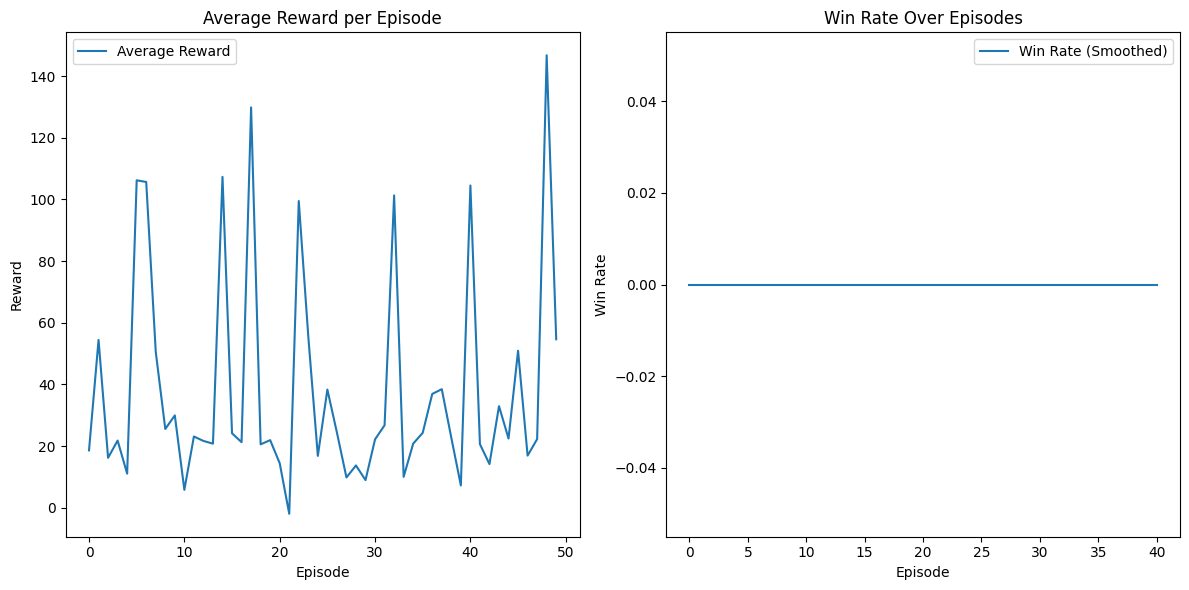

Training completed.


blue_player1_reward,▂▅▃▂▃▃▄▂▃▁▂▂▄▂▂▂▂▁▂█▂▄▃▂▂▂▂▃▂▂▃▂▆▂▂▂▅▂▂▅
blue_player2_reward,▂▃▂▂▁█▃▃▃▂▃▃█▃▃▂▂▃▁▄▂▂▂▂▂▃█▂▂▃▃▂▆▃▂▃▃▂▃▃
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
score,▅▅▅▅▇▆▃▄▄▅▅▆▅▅█▃▅▇▅▅▅▅▅▄▅▇▅▅▄▅▁▅▇▅▅▅▆▅▄▆
blue_player1_reward,33.33
blue_player2_reward,21.33
episode,49
score,4


episode:   0
enemy: baselineTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/baselineTeam.py
Arguments: {}
Blue team starts


/tmp/ipykernel_221298/1696682486.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
/tmp/ipykernel_221298/1696682486.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


defended
-5.9799999999999995
-5.2299999999999995
Episode reward: -11.209999999999999
episode:   1
enemy: baselineTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/baselineTeam.py
Arguments: {}
Blue team starts
-5.949999999999999
-5.949999999999999
Episode reward: -11.899999999999999
episode:   2
enemy: baselineTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/baselineTeam.py
Arguments: {}
Blue team starts
-5.889999999999999
-5.889999999999999
Episode reward: -11.779999999999998
episode:   3
enemy: baselineTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/baselineTeam.py
Arguments: {}
Red team starts
defended
defended
defended
-0.13000000000003986
0.6199999999999601
Episode reward: 0.4899999999999203
episode:   4
enemy: baselineTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/baselineTeam.py
Arguments: {}
Blue team starts
captured food
captured food
captured food
captured food
captured food
captured food
defended
defen

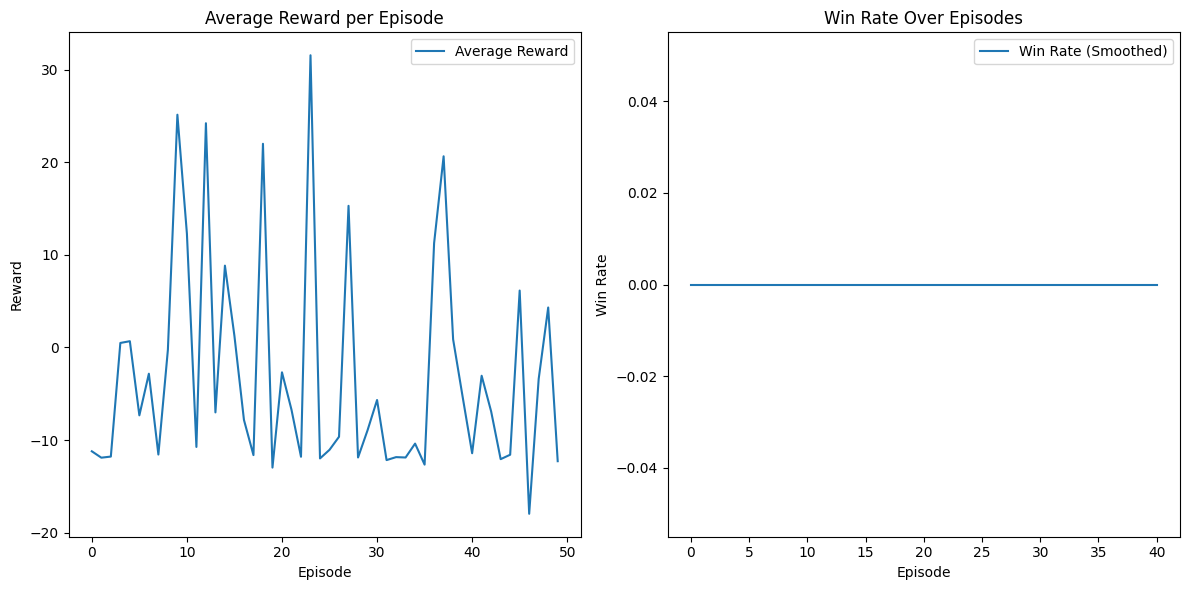

Training completed.


blue_player1_reward,▃▃▃▅▄▅▃▇▇▃▄▅▅▄▃▅▅▄▃█▃▃█▄▄▃▃▄▂▅▄▄▃▅▄▃▆▁▄▃
blue_player2_reward,▃▂▂▄▄▃▂▂▇▄▆▃▆▄▃▁▃▃▂█▃▄▂▃▃▂▂▂▃▆▅▄▂▃▃▂▄▃▃▂
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
score,▁▁▁▁▁▁███▁▁▁▁▁█▁▁▁█▁▁█▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁
blue_player1_reward,-6.14
blue_player2_reward,-6.14
episode,49
score,-37


episode:   0
enemy: heuristicTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/heuristicTeam.py
Arguments: {}
Blue team starts


/tmp/ipykernel_221298/1696682486.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
/tmp/ipykernel_221298/1696682486.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


captured food
captured food
reset counter
3.959999999999989
-4.040000000000043
Episode reward: -0.0800000000000538
episode:   1
enemy: heuristicTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/heuristicTeam.py
Arguments: {}
Blue team starts
captured food
captured food
5.849999999999969
3.8499999999999894
Episode reward: 9.699999999999958
episode:   2
enemy: heuristicTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/heuristicTeam.py
Arguments: {}
Red team starts
captured food
captured food
captured food
4.929999999999978
5.929999999999984
Episode reward: 10.859999999999962
episode:   3
enemy: heuristicTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/heuristicTeam.py
Arguments: {}
Blue team starts
captured food
3.009999999999989
4.009999999999989
Episode reward: 7.019999999999978
episode:   4
enemy: heuristicTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/heuristicTeam.py
Arguments: {}
Blue team starts
reset counter


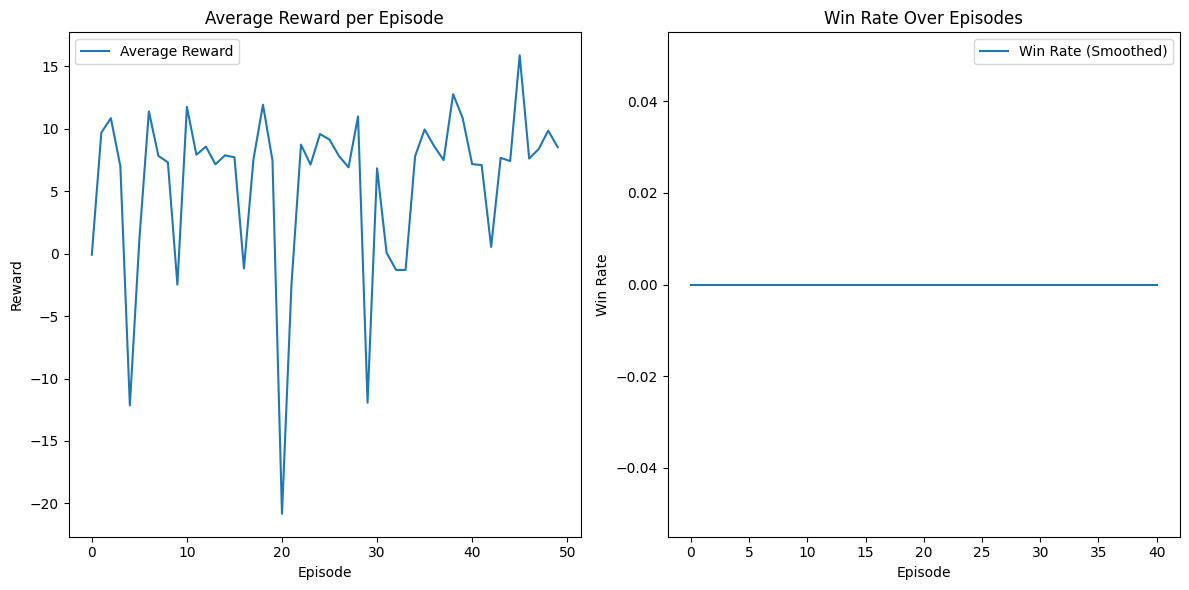

Training completed.


blue_player1_reward,▆▇▇▆▁█▆▆█▆▆▆▆▇▆▆▆▁▇▆▆▆▆█▁▇▂▂▆▇▆██▆▆▆▆▆▆▆
blue_player2_reward,▅▇▇▇▅▇▇▇▇▇▇▆▇▆▅▇▁▇▇▆▇▇▆▇▅▅▇▇▇▇▇▇▇▆▅▇█▇▇▇
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
score,▄▅▄▅▄▄▅▄▅▅▅▄▅▇▄▃▄▅▅▄▄▁▅▄▅▄▇▅▅▄▅▅▄▄█▅▁▂█▅
blue_player1_reward,3.77
blue_player2_reward,4.77
episode,49
score,-26


episode:   0
enemy: approxQTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/approxQTeam.py
Arguments: {}
Blue team starts


/tmp/ipykernel_221298/1696682486.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
/tmp/ipykernel_221298/1696682486.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


-5.81
-5.81
Episode reward: -11.62
episode:   1
enemy: approxQTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/approxQTeam.py
Arguments: {}
Red team starts
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
captured food
gave food to side
number of food: 4
captured food
captured food
captured food
captured food
captured food
gave food to side
number of food: 4
61.66000000000002
24.66000000000004
Episode reward: 86.32000000000005
episode:   2
enemy: approxQTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/approxQTeam.py
Arguments: {}
Blue team starts
defended
defended
captured food
captured food
captured food
captured food
gave food to side
number of food: 2
captured food
captured food
21.54000000000007
11.039999999999951
Episode reward: 32.58000000000002
episode:   3
enemy: approxQTeam.py
Loading Team: /home/seppe/RL/proje

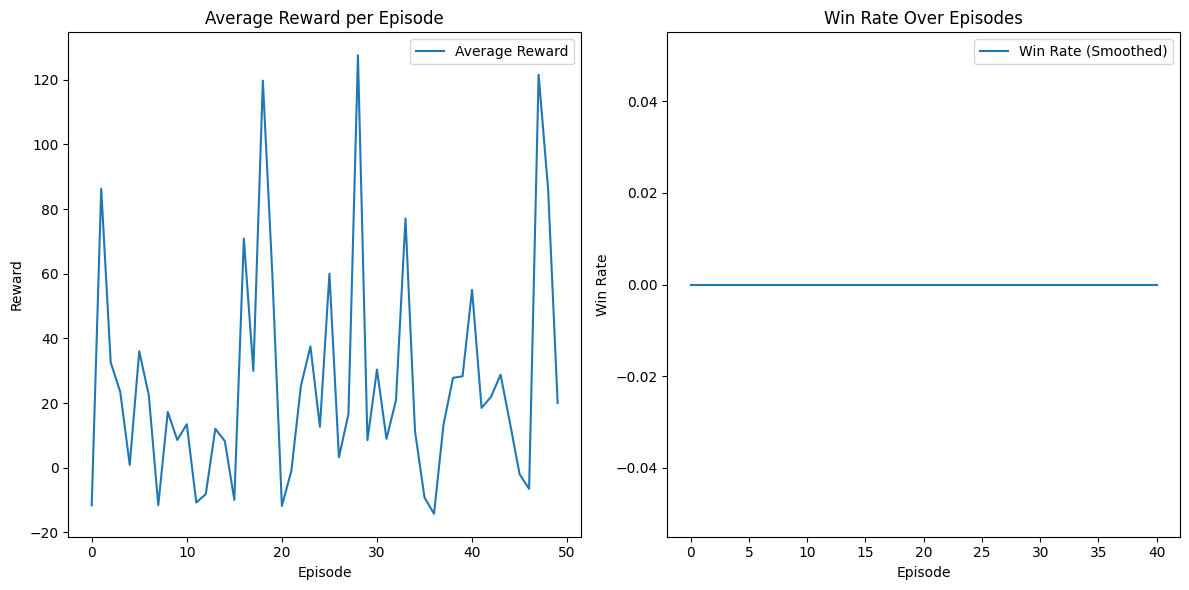

Training completed.


blue_player1_reward,▁█▃▁▄▁▂▂▃▁▂▂▁▂▃▆▁▁▄▃▂▂▄▃▃▂▇▂▁▂▃▃▅▂▂▃▃▁▄▁
blue_player2_reward,▁▃▂▃▂▁▃▂▂▁▂▂▂▆▃▃▁▂▃▃▃▂█▂▃▃▃▂▂▁▃▃▃▃▃▂▁▂█▃
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
score,▁▃▂█▁▁▁▁▁▁▁▁▁▁▃▄▂▁▁▁▂█▁▄▁▁▂▁▁▁▁▁▂▁▁▁▁▁▄▁
blue_player1_reward,-1.24
blue_player2_reward,21.26
episode,49
score,-35


episode:   0
enemy: MCTSTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/MCTSTeam.py
Arguments: {}
Blue team starts
index 0, action South, depth 121


/tmp/ipykernel_221298/1696682486.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
/tmp/ipykernel_221298/1696682486.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


index 2, action North, depth 123
index 0, action North, depth 124
index 2, action North, depth 125
index 0, action South, depth 123
index 2, action North, depth 123
index 0, action North, depth 123
index 2, action South, depth 124
index 0, action South, depth 123
index 2, action South, depth 123
index 0, action North, depth 124
index 2, action South, depth 125
index 0, action South, depth 123
index 2, action North, depth 122
index 0, action North, depth 124
index 2, action North, depth 123
index 0, action South, depth 123
index 2, action North, depth 124
index 0, action North, depth 124
index 2, action North, depth 123
index 0, action South, depth 124
index 2, action South, depth 124
index 0, action North, depth 125
index 2, action South, depth 124
index 0, action South, depth 123
index 2, action South, depth 124
index 0, action South, depth 123
index 2, action South, depth 124
index 0, action North, depth 125
index 2, action North, depth 123
index 0, action North, depth 123
index 2, a

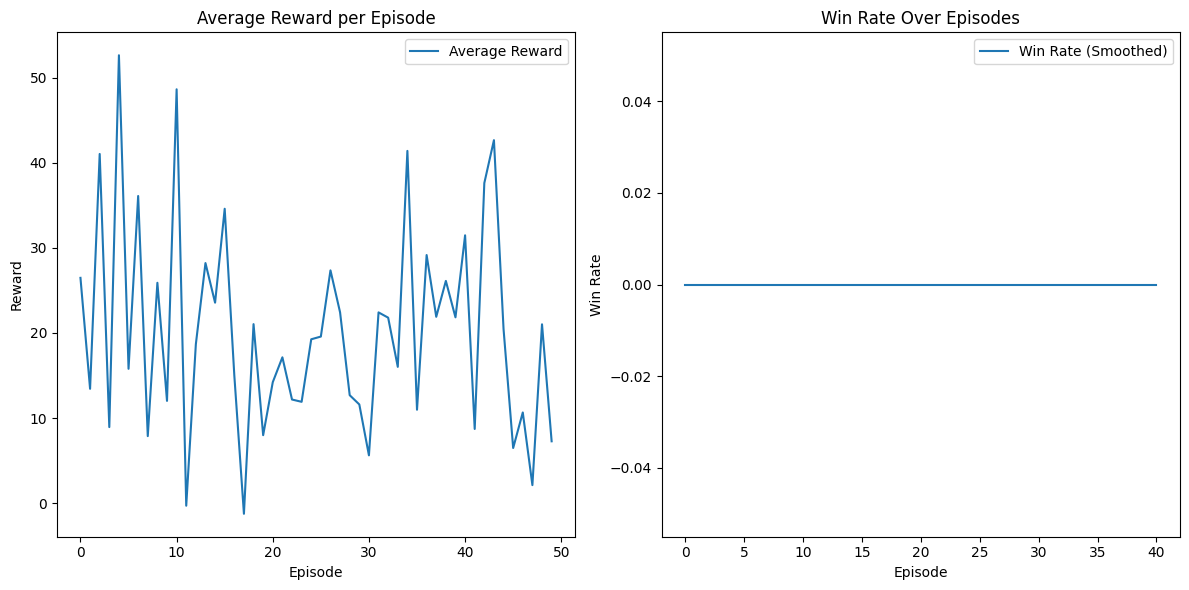

Training completed.


blue_player1_reward,▄▂▆▂▆▅▂▃█▂▂▂▃▂▂▂▂▂▂▁▂▃▂▃▃▂▁▆▂▂▃▂▄▂▅▃▃▂▁▂
blue_player2_reward,▅▅▄▃▇▃▇▃▃▂▇▇▇▄▁▄▄▅▄▆▆▆▆▃▃▆▇▅▄█▆▆▅▃▆▄▂▄▄▃
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
score,▅▅▇▇█▄▆▃▆█▆▆▃▆▄▇▃▃▇▆▆▆▃▇▄▄▅█▄▆▇▇▇▇▆▅▅▅▁▇
blue_player1_reward,3.26
blue_player2_reward,4.01
episode,49
score,0


episode:   0
enemy: AstarTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/AstarTeam.py
Arguments: {}
Red team starts


/tmp/ipykernel_221298/1696682486.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)
/tmp/ipykernel_221298/1696682486.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs_agent, dtype=torch.float32).to(device)


reset counter
captured food
captured food
captured food
reset counter
-3.8300000000000303
-4.830000000000021
Episode reward: -8.660000000000052
episode:   1
enemy: AstarTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/AstarTeam.py
Arguments: {}
Blue team starts
defended
4.459999999999983
3.709999999999989
Episode reward: 8.169999999999972
episode:   2
enemy: AstarTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/AstarTeam.py
Arguments: {}
Red team starts
NotSolutionFound
3.4599999999999866
3.4599999999999866
Episode reward: 6.919999999999973
episode:   3
enemy: AstarTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/AstarTeam.py
Arguments: {}
Red team starts
3.2899999999999894
3.2899999999999894
Episode reward: 6.579999999999979
episode:   4
enemy: AstarTeam.py
Loading Team: /home/seppe/RL/project3/RL_MARL_QMIX//agents/AstarTeam.py
Arguments: {}
Blue team starts
captured food
3.9399999999999875
4.9399999999999755
Episode reward: 8.8799

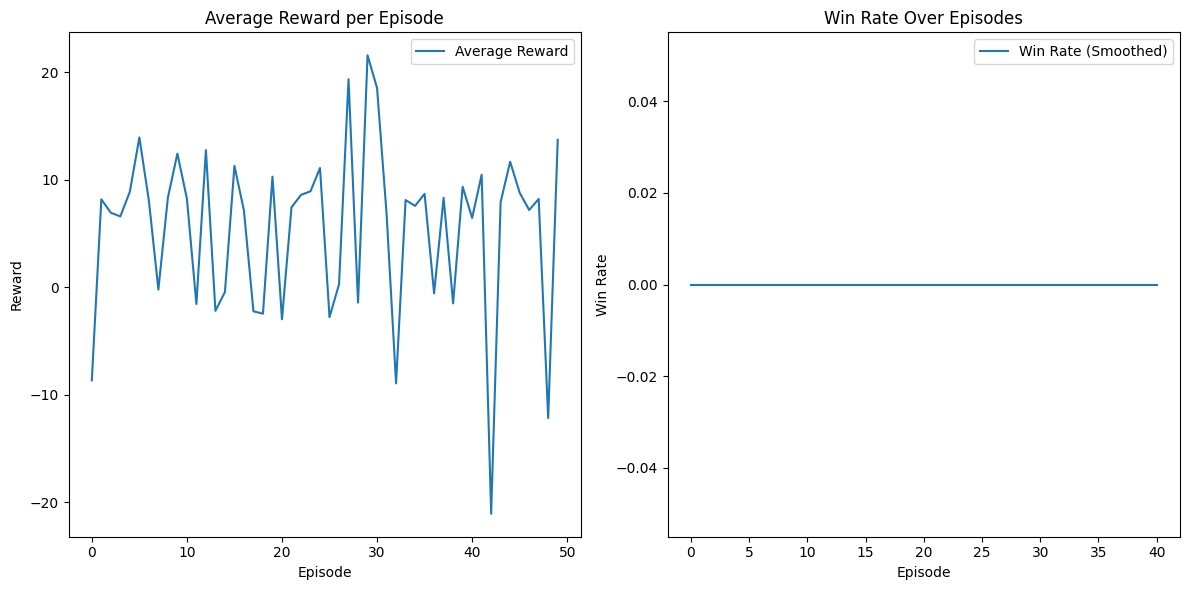

Training completed.


blue_player1_reward,▄▇▆▆▇▇▇▆▇▆█▇▆▇▆▄▆▆▆▇▇▆▆▇▇▄▆▆▇▆▇▇▇▇▁▇▆▆▇█
blue_player2_reward,▂▄▄▄▅▁▅▆▅▁▁▂▄▁▄▁▄▄▄▄▂▇▁██▂▅▄▄▂▁▅▄▅▂▅▅▄▄▅
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
score,▆▆█▆▆▅▁▇█▆▆▅▂▆▆█▅█▅▇▃▃▇▇▇▅▅▇▇▇▆▅▇▇▅▇▅▅▆▅
blue_player1_reward,9.35
blue_player2_reward,4.35
episode,49
score,-27


In [36]:
name_experiment ='PPO_bloxCapture_baseline'
team_name = 'RL_PacMan_PPO'
wandb.init(project="", id = f"{'random'}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_ppo(env, agent_networks, value_networks, 0.995,50,False,'randomTeam.py')
wandb.finish()
wandb.init(project="", id = f"{'baseline'}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_ppo(env, agent_networks, value_networks, 0.995,50,False,'baselineTeam.py')
wandb.finish()
wandb.init(project="", id = f"{'heuristic'}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_ppo(env, agent_networks, value_networks, 0.995,50,False,'heuristicTeam.py')
wandb.finish()
wandb.init(project="", id = f"{'approxQ'}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_ppo(env, agent_networks, value_networks, 0.995,50,False,'approxQTeam.py')
wandb.finish()
wandb.init(project="", id = f"{'MCTS'}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_ppo(env, agent_networks, value_networks, 0.995,50,False,'MCTSTeam.py')
wandb.finish()
wandb.init(project="", id = f"{'ASTAR'}__{datetime.now().strftime('%Y%m%d_%H%M%S')}")
train_ppo(env, agent_networks, value_networks, 0.995,50,False,'AstarTeam.py')
wandb.finish()